# [지역 및 업종 임베딩 활용한 새로운 지역 경제 지표 제시]
## : NMF, NCF, GMF 모델을 활용한 Representation Learning

# 목차

## 1. 광역시도별 업종별 가맹점 데이터

### 1-1. 군집화를 활용한 Label 생성
#### (1) 데이터 불러오기
#### (2) 데이터 전처리 및 피쳐 생성
#### (3) 가맹점을 반영하는 Label
#### (4) 매출을 반영하는 Label
#### (5) 최종 Label 생성

### 1-2. 변동 계수(CV)를 고려한 Label 생성
#### (1) 데이터 불러오기
#### (2) 점당매출금액을 활용한 변동계수 함수
#### (3) 분위수를 활용한 점수 산출을 위해 각 지표에 따른 기준점 도출 함수
#### (4) 산출한 기준점을 바탕으로 점수 부여 함수
#### (5) 데이터 전처리
#### (6) Label 생성을 위한 함수 적용
#### (7) 업종대분류와 시군구 점수를 합산한 최종 Label 생성
#### (8) 데이터 저장

### 1-3. Model
#### (1) 데이터 불러오기
#### (2) 라벨인코딩
#### (3) 데이터 스플릿
#### (4) 모델 기본 설정
#### (5) GMF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (6) NCF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (7) NMF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (8) 결과

## 2. 기업통계 금융보안원

### 2-1. 군집화를 활용한 Label 생성
#### (1) 데이터 불러오기
#### (2) 매출 classing
#### (3) 영업이익 classing
#### (4) 시각화
#### (5) 최종 Label 생성

### 2-2. 변동 계수(CV)를 고려한 Label 생성
#### (1) 데이터 불러오기
#### (2) 영업이익중위액을 활용한 변동계수(CV) 함수
#### (3) 분위수를 활용한 점수 산출을 위해 각 지표에 따른 기준점 도출 함수
#### (4) 산출한 기준점을 바탕으로 점수 부여 함수
#### (5) 데이터 전처리
#### (6) Label 생성을 위한 함수 적용
#### (7) 업종대분류와 시군구 점수를 합산한 최종 Label 생성
#### (8) 데이터 저장

### 2-3. Model
#### (1) 데이터 불러오기
#### (2) 라벨인코딩
#### (3) 데이터 스플릿
#### (4) 모델 기본 설정
#### (5) GMF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (6) NCF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (7) NMF
##### - 모델 정의
##### - 학습
##### - 학습 결과
##### - 예측
##### - 임베딩 시각화
#### (8) 결과

## 3. Tableau 시각화
### 3-1. 지역별 통계 데이터
#### (1) 전국
#### (2) 서울시 (신한은행 서울시 데이터)
### 3-2. 광역시도별 업종별 가맹점 데이터

# 1.광역시도별 업종별 가맹점 데이터

## 1-1. 군집화를 활용한 Label 생성

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

!apt -qq -y install fonts-nanum                 # 상기 라이브러리에 폰트 설치 
                                                # 이하 기본 폰트가 되도록 설정
# 한글 폰트를 사용할 수 있게 만들어줌
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') # 그래프에서 한글 깨지는 현상 방지
plt.rc('axes', unicode_minus=False) # 그래프에서 마이너스 기호가 표시되도록
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


### (1) 데이터 불러오기


In [ ]:
PATHS = '/content/drive/MyDrive/금융데이터 공모전/Data/'

In [ ]:
df = pd.read_excel(PATHS + '광역시도별_Data_input.xlsx')
df.head()

,기준년월,광역시도명,업종대분류,업종중분류,업종소분류,신규가맹점수,해지가맹점수,매출가맹점수,카드매출금액,카드매출건수,점당매출금액,건당매출금액
0,201903,강원,문화레져,동물,동물농장,3,1,12,16036000,500,1336292,32071
1,201903,강원,문화레져,동물,애완동물/용품,5,1,190,283445000,7826,1491816,36218
2,201903,강원,문화레져,동물병원,병원-동물병원,0,1,88,341305000,4910,3878461,69512
3,201903,강원,문화레져,레져,골프장,0,1,80,3575639000,25016,44695491,142934
4,201903,강원,문화레져,레져,낚시터,1,1,3,748000,9,249333,83111


### (2) 데이터 전처리 및 피쳐 생성
: 해지가맹점비와 업종별해지가맹점비를 나눈 target 변수 생성


In [ ]:
df = df.reset_index(drop = True)
df = df.dropna()
df = df[df['매출가맹점수'] != 0].reset_index(drop = True)
df = df[df['카드매출금액'] > 0].reset_index(drop = True)
df = df[df['카드매출건수'] > 0].reset_index(drop = True)

In [ ]:
df['과거총가맹점수'] = df['해지가맹점수'] + df['매출가맹점수']
df['해지가맹점비'] = df['해지가맹점수'] / df['과거총가맹점수']

In [ ]:
year_li = df['기준년월'].unique()

_df_li = []

for year in year_li:
  _df = df[df['기준년월'] == year]
  d = (_df.groupby('업종중분류')['해지가맹점수'].mean()/_df.groupby('업종중분류')['매출가맹점수'].mean()).reset_index()
  d.rename(columns={0:'업종별해지가맹점비'},inplace=True)
  n = (_df.groupby('업종중분류')['신규가맹점수'].mean()/_df.groupby('업종중분류')['매출가맹점수'].mean()).reset_index()
  n.rename(columns={0:'업종별신규가맹점비'}, inplace=True)
  _df = pd.merge(pd.merge(_df, d, how='left'), n ,how='left')
  _df_li.append(_df)

In [ ]:
df = pd.concat(_df_li).reset_index(drop = True)
df['target'] = (df['해지가맹점비']/df['업종별해지가맹점비'])

In [ ]:
df = df.fillna(0)

### (3) 가맹점을 반영하는 Label
: 해지가맹점수, 매출가맹점수, target을 활용한 Label 생성

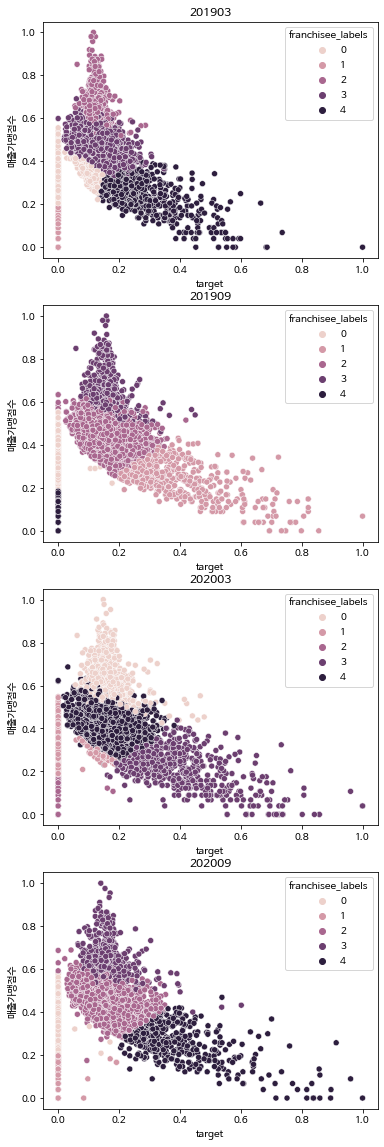

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

n_cluster = 5
clusterer = KMeans(n_clusters = n_cluster, random_state=22)
# clusterer = GaussianMixture(n_components = n_cluster, random_state=22)

year_li = df['기준년월'].unique()
cols = ['해지가맹점수', '매출가맹점수', 'target']

result_li = []

fig, axs = plt.subplots(figsize=(6, 5 * len(year_li)), nrows = len(year_li), ncols = 1)

for idx, year in enumerate(year_li):
  _df = df[df['기준년월'] == year]

  X = _df[cols]
  X = np.log1p(X)
  X = (X - X.min()) / (X.max() - X.min())

  cluster_labels = clusterer.fit_predict(X)

  X['franchisee_labels'] = cluster_labels
  X['기준년월'] = year

  axs[idx].set_title(str(year))
  sns.scatterplot(data = X, x='target', y='매출가맹점수', hue = 'franchisee_labels', ax = axs[idx])

  result_li += [X]

result = pd.concat(result_li)

In [ ]:
result.groupby(['기준년월', 'franchisee_labels']).mean()

해지가맹점수    매출가맹점수    target
기준년월   franchisee_labels                              
201903 0                  0.016009  0.302403  0.016133
       1                  0.000000  0.084056  0.000000
       2                  0.519664  0.675597  0.128869
       3                  0.234553  0.475554  0.131311
       4                  0.134898  0.238089  0.288231
201909 0                  0.000267  0.293515  0.000360
       1                  0.134356  0.233608  0.399718
       2                  0.185588  0.446529  0.157860
       3                  0.467319  0.653358  0.164441
       4                  0.000000  0.083984  0.000000
202003 0                  0.478294  0.633792  0.171339
       1                  0.003298  0.281718  0.004305
       2                  0.000124  0.081143  0.000214
       3                  0.140879  0.209181  0.396697
       4                  0.190498  0.432810  0.157433
202009 0                  0.000263  0.307170  0.000295
       1                  0.000374  0.090770  0.000386
       2                  0.182749  0.457092  0.159017
       3                  0.461276  0.653119  0.166856
       4                  0.142892  0.246729  0.407517

In [ ]:
def get_franchisee_label(x):
  _year = x['기준년월']
  _franchisee_labels = x['franchisee_labels']
  if year == 201903:
    if _franchisee_labels == 0 : return 1
    if _franchisee_labels == 1 : return 4
    if _franchisee_labels == 2 : return 2
    if _franchisee_labels == 3 : return 3
    if _franchisee_labels == 4 : return 5
  
  elif year == 201909:
    if _franchisee_labels == 0 : return 1
    if _franchisee_labels == 1 : return 5
    if _franchisee_labels == 2 : return 3
    if _franchisee_labels == 3 : return 2
    if _franchisee_labels == 4 : return 4

  elif year == 202003:
    if _franchisee_labels == 0 : return 2
    if _franchisee_labels == 1 : return 1
    if _franchisee_labels == 2 : return 4
    if _franchisee_labels == 3 : return 5
    if _franchisee_labels == 4 : return 3

  elif year == 202009:
    if _franchisee_labels == 0 : return 1
    if _franchisee_labels == 1 : return 4
    if _franchisee_labels == 2 : return 3
    if _franchisee_labels == 3 : return 2
    if _franchisee_labels == 4 : return 5

df['franchise_label'] = result.apply(lambda x: get_franchisee_label(x), axis = 1)

### (4) 매출을 반영하는 Label
: 카드매출건수, 카드매출금액, 점당매출금액, 건당매출금액을 활용한 Label 생성


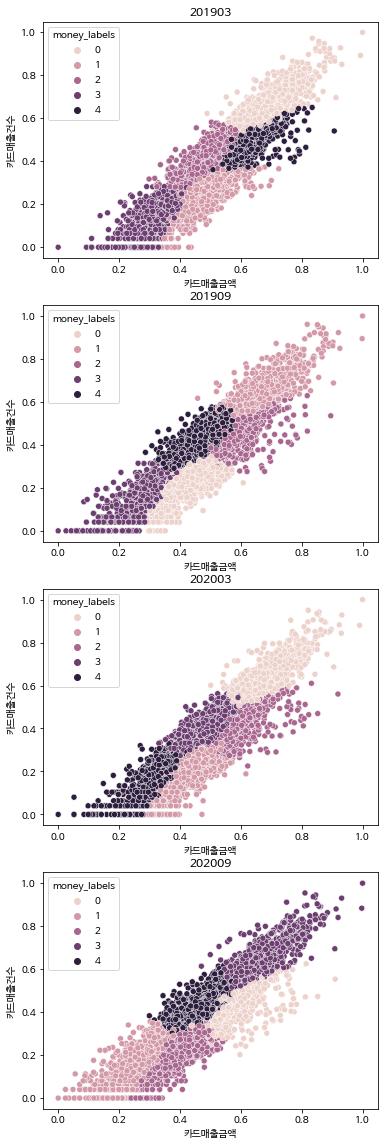

In [ ]:
from sklearn.cluster import KMeans

n_cluster = 5
clusterer = KMeans(n_clusters = n_cluster, random_state=22)

year_li = df['기준년월'].unique()
cols = ['카드매출건수', '카드매출금액', '점당매출금액', '건당매출금액']

result_li = []

fig, axs = plt.subplots(figsize=(6, 5 * len(year_li)), nrows = len(year_li), ncols = 1)

for idx, year in enumerate(year_li):
  _df = df[df['기준년월'] == year]

  X = _df[cols]
  X = np.log(X)
  X = (X - X.min()) / (X.max() - X.min())

  cluster_labels = clusterer.fit_predict(X)

  X['money_labels'] = cluster_labels
  X['기준년월'] = year

  axs[idx].set_title(str(year))
  sns.scatterplot(data = X, x='카드매출금액', y='카드매출건수', hue = 'money_labels', ax = axs[idx])

  result_li += [X]

result = pd.concat(result_li)

In [ ]:
result.groupby(['기준년월', 'money_labels']).mean()

카드매출건수    카드매출금액    점당매출금액    건당매출금액
기준년월   money_labels                                        
201903 0             0.661589  0.689815  0.524087  0.349638
       1             0.254120  0.482870  0.457267  0.602459
       2             0.415799  0.496594  0.425301  0.360844
       3             0.139028  0.314590  0.335193  0.446961
       4             0.481169  0.619974  0.483698  0.506602
201909 0             0.229262  0.425098  0.412648  0.583957
       1             0.650386  0.670714  0.504653  0.359167
       2             0.450658  0.595266  0.471938  0.546041
       3             0.151774  0.271309  0.289980  0.412922
       4             0.430043  0.485543  0.396776  0.365977
202003 0             0.635409  0.682494  0.515667  0.360777
       1             0.207496  0.436382  0.422265  0.570510
       2             0.421757  0.602668  0.490840  0.553024
       3             0.415392  0.506701  0.413725  0.368486
       4             0.158492  0.307698  0.315184  0.390220
202009 0             0.433252  0.585619  0.468362  0.561277
       1             0.172228  0.261804  0.272458  0.384614
       2             0.224605  0.402581  0.383190  0.563193
       3             0.642746  0.664878  0.489394  0.362007
       4             0.436158  0.484970  0.373673  0.366403

In [ ]:
def get_money_label(x):
  _year = x['기준년월']
  _money_labels = x['money_labels']
  if year == 201903:
    if _money_labels == 0 : return 1
    if _money_labels == 1 : return 4
    if _money_labels == 2 : return 3
    if _money_labels == 3 : return 5
    if _money_labels == 4 : return 2
  
  elif year == 201909:
    if _money_labels == 0 : return 4
    if _money_labels == 1 : return 1
    if _money_labels == 2 : return 2
    if _money_labels == 3 : return 5
    if _money_labels == 4 : return 3

  elif year == 202003:
    if _money_labels == 0 : return 1
    if _money_labels == 1 : return 4
    if _money_labels == 2 : return 2
    if _money_labels == 3 : return 3
    if _money_labels == 4 : return 5

  elif year == 202009:
    if _money_labels == 0 : return 2
    if _money_labels == 1 : return 5
    if _money_labels == 2 : return 4
    if _money_labels == 3 : return 1
    if _money_labels == 4 : return 3

df['money_label'] = result.apply(lambda x: get_money_label(x), axis = 1)

### (5) 최종 Label 생성
: 가맹점을 반영하는 Label과 매출을 반영하는 Label을 서로 곱해 최종 Label 생성

In [ ]:
df['label'] = df['franchise_label'] * df['money_label']

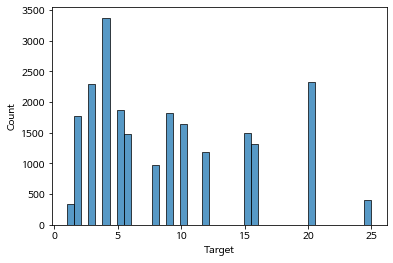

In [ ]:
sns.histplot(df['label'])

## 1-2. 변동 계수(CV)를 고려한 Label 생성

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import sys
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings(action='ignore')

### (1) 데이터 불러오기

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/금융데이터 공모전/Data/광역시도별_Data_input.xlsx')
df = df[~df['업종대분류'].isnull()]
df

,기준년월,광역시도명,업종대분류,업종중분류,업종소분류,신규가맹점수,해지가맹점수,매출가맹점수,카드매출금액,카드매출건수,점당매출금액,건당매출금액
0,201903,강원,문화레져,동물,동물농장,3,1,12,16036000,500,1336292,32071
1,201903,강원,문화레져,동물,애완동물/용품,5,1,190,283445000,7826,1491816,36218
2,201903,강원,문화레져,동물병원,병원-동물병원,0,1,88,341305000,4910,3878461,69512
3,201903,강원,문화레져,레져,골프장,0,1,80,3575639000,25016,44695491,142934
4,201903,강원,문화레져,레져,낚시터,1,1,3,748000,9,249333,83111
...,...,...,...,...,...,...,...,...,...,...,...,...
23886,202009,충북,종합유통,전용매장,보훈매장,0,0,1,386000,40,386300,9658
23887,202009,충북,종합유통,전용매장,복지매점,0,0,5,2199000,415,439877,5300
23888,202009,충북,종합유통,전용매장,사원전용매장,0,0,10,82163000,3971,8216280,20691
23889,202009,충북,종합유통,전용매장,연금매장,0,0,3,36451000,1602,12150400,22754


### (2) 점당매출금액을 활용한 변동계수 함수
: 광역시도명 및 기준년월과 업종대분류 및 기준년월에 따른 변동계수 산출


In [ ]:
def sigun_cv(df):
    for s in tqdm(list(sigun)):
        for c in list(comp):
            df.loc[(df['광역시도명']==s) & (df['기준년월']==c),'시군구_CV'] = np.std(df[(df['광역시도명']==s) & (df['기준년월']==c)]['점당매출금액']) / (np.mean(df[(df['광역시도명']==s) & (df['기준년월']==c)]['점당매출금액'])+ eps)
    df.시군구_CV = df.시군구_CV.astype(float)
    return df  

def upjong_cv(df):
    for s in tqdm(list(upjong)):
        for c in list(comp):
            df.loc[(df['업종대분류']==s) & (df['기준년월']==c),'업종대분류명_CV'] = np.std(df[(df['업종대분류']==s) & (df['기준년월']==c)]['점당매출금액']) /  (np.mean(df[(df['업종대분류']==s) & (df['기준년월']==c)]['점당매출금액'])+ eps)
    df.업종대분류명_CV = df.업종대분류명_CV.astype(float)
    return df   


### (3) 분위수를 활용한 점수 산출을 위해 각 지표에 따른 기준점 도출 함수
: 기준년월에 따른 점당매출금액, 시군구별 점당매출금액 변동계수, 업종대분류명별 점당매출금액 변동계수

In [ ]:
def get_quantile(df, col):
  ret_quantile = {}
  for i in range(1, 10):
    ret_li = df.groupby([col,'기준년월']).quantile(0.1 * i)['점당매출금액']
    for key, val in zip(ret_li.index, ret_li.values):
      if i == 1:
        ret_quantile[key] = [val]
      else:
        ret_quantile[key] += [val]

  return ret_quantile

def get_quantile_sigun(df, col):
  ret_quantile = {}
  for i in range(1, 10):
    ret_li = df.groupby([col,'기준년월']).quantile(0.1 * i)['시군구_CV']
    for key, val in zip(ret_li.index, ret_li.values):
      if i == 1:
        ret_quantile[key] = [val]
      else:
        ret_quantile[key] += [val]

  return ret_quantile

def get_quantile_upjong(df, col):
    ret_quantile = {}
    for i in range(1, 10):
        ret_li = df.groupby([col,'기준년월']).quantile(0.1 * i)['업종대분류명_CV']
        for key, val in zip(ret_li.index, ret_li.values):
            if i == 1:
                ret_quantile[key] = [val]
            else:
                ret_quantile[key] += [val]

    return ret_quantile 

### (4) 산출한 기준점을 바탕으로 점수 부여 함수
: 10분위수로 나누어 점수가 높을 수록 해당 데이터가 긍정적인 것을 나타냄

In [ ]:
def get_Incomes(quantile_li, col, df):
  li = quantile_li[tuple(df[[col,'기준년월']])]
  x = df['점당매출금액']
  if x < li[0] : return 1
  elif x < li[1] : return 2
  elif x < li[2] : return 3
  elif x < li[3] : return 4
  elif x < li[4] : return 5
  elif x < li[5] : return 6
  elif x < li[6] : return 7
  elif x < li[7] : return 8
  elif x < li[8] : return 9
  else: return 10

def get_CV(quantile_li, col, df,cv_col):
  li = quantile_li[tuple(df[[col,'기준년월']])]
  x = df[cv_col]
  if x < li[0] : return 10
  elif x < li[1] : return 9
  elif x < li[2] : return 8
  elif x < li[3] : return 7
  elif x < li[4] : return 6
  elif x < li[5] : return 5
  elif x < li[6] : return 4
  elif x < li[7] : return 3
  elif x < li[8] : return 2
  else: return 1

### (5) 데이터 전처리
: Train 데이터는 2019년까지, Test 데이터는 2020년으로 산정하여 전처리를 진행

In [ ]:
Train = df[df['기준년월'] != 202009].reset_index(drop=True)
Test = df[df['기준년월'] == 202009].reset_index(drop=True)
Test =  Test[~(Test['업종중분류'] == '학원')]

mm = MinMaxScaler()
Train.loc[Train['기준년월'] == 201903,'점당매출금액'] = mm.fit_transform(Train[Train['기준년월'] == 201903][['점당매출금액']])
Train.loc[Train['기준년월'] == 201909,'점당매출금액'] = mm.fit_transform(Train[Train['기준년월'] == 201909][['점당매출금액']])
Train.loc[Train['기준년월'] == 202003,'점당매출금액'] = mm.fit_transform(Train[Train['기준년월'] == 202003][['점당매출금액']])

Train_2018 = Train[Train['기준년월'] == 201903]
Train_2019 = Train[Train['기준년월'] == 201909]
Train_2020 = Train[Train['기준년월'] == 202003]

### (6) Label 생성을 위한 함수 적용


In [ ]:
eps = sys.float_info.epsilon

comp = Train['기준년월'].unique()
sigun = Train['광역시도명'].unique()
upjong = Train['업종대분류'].unique()

sigun_cv(Train_2018)
sigun_cv(Train_2019)
sigun_cv(Train_2020)     

upjong_cv(Train_2018)
upjong_cv(Train_2019)
upjong_cv(Train_2020)

city_2018_CV_quantile = get_quantile_sigun(Train_2018, '광역시도명')
city_2019_CV_quantile = get_quantile_sigun(Train_2019, '광역시도명')
city_2020_CV_quantile = get_quantile_sigun(Train_2020, '광역시도명')

sector_2018_CV_quantile = get_quantile_upjong(Train_2018, '업종대분류')
sector_2019_CV_quantile = get_quantile_upjong(Train_2019, '업종대분류')
sector_2020_CV_quantile = get_quantile_upjong(Train_2020, '업종대분류')

city_2018_quantile = get_quantile(Train_2018, '광역시도명')
city_2019_quantile = get_quantile(Train_2019, '광역시도명')
city_2020_quantile = get_quantile(Train_2020, '광역시도명')

sector_2018_quantile = get_quantile(Train_2018, '업종대분류')
sector_2019_quantile = get_quantile(Train_2019, '업종대분류')
sector_2020_quantile = get_quantile(Train_2020, '업종대분류')

Train_2018['cat_시군구_CV'] = Train_2018.apply(lambda x : get_CV(city_2018_CV_quantile, '광역시도명', x,'시군구_CV'), axis = 1)
Train_2019['cat_시군구_CV'] = Train_2019.apply(lambda x : get_CV(city_2019_CV_quantile, '광역시도명', x,'시군구_CV'), axis = 1)
Train_2020['cat_시군구_CV'] = Train_2020.apply(lambda x : get_CV(city_2020_CV_quantile, '광역시도명', x,'시군구_CV'), axis = 1)

Train_2018['cat_업종_CV'] = Train_2018.apply(lambda x : get_CV(sector_2018_CV_quantile, '업종대분류', x,'업종대분류명_CV'), axis = 1)
Train_2019['cat_업종_CV'] = Train_2019.apply(lambda x : get_CV(sector_2019_CV_quantile, '업종대분류', x,'업종대분류명_CV'), axis = 1)
Train_2020['cat_업종_CV'] = Train_2020.apply(lambda x : get_CV(sector_2020_CV_quantile, '업종대분류', x,'업종대분류명_CV'), axis = 1)

Train_2018['cat_시군구_점당매출금액'] = Train_2018.apply(lambda x : get_Incomes(city_2018_quantile, '광역시도명', x), axis = 1)
Train_2019['cat_시군구_점당매출금액'] = Train_2019.apply(lambda x : get_Incomes(city_2019_quantile, '광역시도명', x), axis = 1)
Train_2020['cat_시군구_점당매출금액'] = Train_2020.apply(lambda x : get_Incomes(city_2020_quantile, '광역시도명', x), axis = 1)

Train_2018['cat_업종_점당매출금액'] = Train_2018.apply(lambda x : get_Incomes(sector_2018_quantile, '업종대분류', x), axis = 1)
Train_2019['cat_업종_점당매출금액'] = Train_2019.apply(lambda x : get_Incomes(sector_2019_quantile, '업종대분류', x), axis = 1)
Train_2020['cat_업종_점당매출금액'] = Train_2020.apply(lambda x : get_Incomes(sector_2020_quantile, '업종대분류', x), axis = 1)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

### (7) 업종대분류와 시군구 점수를 합산한 최종 Label 생성
: 100점을 기준으로 점수 산출

In [ ]:
Train_2018['label_시군구_점당매출금액'] = Train_2018['cat_시군구_점당매출금액'] * Train_2018['cat_시군구_CV']
Train_2019['label_시군구_점당매출금액'] = Train_2019['cat_시군구_점당매출금액'] * Train_2019['cat_시군구_CV']
Train_2020['label_시군구_점당매출금액'] = Train_2020['cat_시군구_점당매출금액'] * Train_2020['cat_시군구_CV']

Train_2018['label_업종_점당매출금액'] = Train_2018['cat_업종_점당매출금액'] * Train_2018['cat_업종_CV']
Train_2019['label_업종_점당매출금액'] = Train_2019['cat_업종_점당매출금액'] * Train_2019['cat_업종_CV']
Train_2020['label_업종_점당매출금액'] = Train_2020['cat_업종_점당매출금액'] * Train_2020['cat_업종_CV']

Train_2018['label'] = Train_2018['label_업종_점당매출금액'] + Train_2018['label_시군구_점당매출금액']
Train_2019['label'] = Train_2019['label_업종_점당매출금액'] + Train_2019['label_시군구_점당매출금액']
Train_2020['label'] = Train_2020['label_업종_점당매출금액'] + Train_2020['label_시군구_점당매출금액']

Train_2018['label'] = mm.fit_transform(Train_2018[['label']]) * 100
Train_2019['label'] = mm.fit_transform(Train_2019[['label']]) * 100
Train_2020['label'] = mm.fit_transform(Train_2020[['label']]) * 100

all_Train = pd.concat([Train_2018, Train_2019, Train_2020]).reset_index(drop = True)

In [ ]:
all_Train.head()

,기준년월,광역시도명,업종대분류,업종중분류,업종소분류,신규가맹점수,해지가맹점수,매출가맹점수,카드매출금액,카드매출건수,점당매출금액,건당매출금액,시군구_CV,업종대분류명_CV,cat_시군구_CV,cat_업종_CV,cat_시군구_점당매출금액,cat_업종_점당매출금액,label_시군구_점당매출금액,label_업종_점당매출금액,label
0,201903,강원,문화레져,동물,동물농장,3,1,12,16036000,500,0.000074,32071,5.478156,2.975646,1,1,5,6,5,6,50.000000
1,201903,강원,문화레져,동물,애완동물/용품,5,1,190,283445000,7826,0.000082,36218,5.478156,2.975646,1,1,5,6,5,6,50.000000
2,201903,강원,문화레져,동물병원,병원-동물병원,0,1,88,341305000,4910,0.000214,69512,5.478156,2.975646,1,1,8,9,8,9,83.333333
3,201903,강원,문화레져,레져,골프장,0,1,80,3575639000,25016,0.002467,142934,5.478156,2.975646,1,1,10,10,10,10,100.000000
4,201903,강원,문화레져,레져,낚시터,1,1,3,748000,9,0.000014,83111,5.478156,2.975646,1,1,1,2,1,2,5.555556


### (8) 데이터 저장

In [ ]:
all_Train.to_csv('/content/drive/MyDrive/금융데이터 공모전/Data/업종별데이터(가맹점)_Train.csv', index=0)
Test.to_csv('/content/drive/MyDrive/금융데이터 공모전/Data/업종별데이터(가맹점)_Test.csv', index=0)

## 1-3. Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings("ignore")

In [ ]:
%config InlineBackend.figure_format = 'retina'  # 레티나 디스플레이 지원을 통해 한글을 선명하게 보여줌
 
!apt -qq -y install fonts-nanum                 # 상기 라이브러리에 폰트 설치 
                                                # 이하 기본 폰트가 되도록 설정
# 한글 폰트를 사용할 수 있게 만들어줌
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


### (1) 데이터 불러오기


In [ ]:
PATHS = '/content/drive/MyDrive/금융데이터 공모전/Data/'
MODEL_DIR = '/content/drive/MyDrive/금융데이터 공모전/Model/'

In [ ]:
Train_df = pd.read_csv(PATHS + '업종별데이터(가맹점)_Train.csv')
Test_df = pd.read_csv(PATHS + '업종별데이터(가맹점)_Test.csv')

### (2) 라벨인코딩
: 임베딩을 위한 리벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cat_cols = ['광역시도명', '업종대분류', '업종중분류', '업종소분류']
all_df = pd.concat([ Train_df[cat_cols], Test_df[cat_cols] ]).reset_index(drop = True)

for col in cat_cols:
  all_df[f'{col}_label'] = encoder.fit_transform(all_df[col].values)
  Train_df[f'{col}_label'] = encoder.transform(Train_df[col].values)
  Test_df[f'{col}_label'] = encoder.transform(Test_df[col].values)

### (3) 데이터 스플릿
: Train과 Val 데이터 분리

In [ ]:
Train = Train_df[Train_df['기준년월'] != 202003]
Val = Train_df[Train_df['기준년월'] == 202003]

### (4) 모델 기본 설정
: Model에 input으로 넣기 위한 데이터 전처리, 데이터 로더 정의, 모델 기본 설정, 학습 / 평가 / 예측 함수 정의

In [ ]:
train_city_idx_li = Train['광역시도명_label'].tolist()
train_big_sector_idx_li = Train['업종대분류_label'].tolist()
train_middle_sector_idx_li = Train['업종중분류_label'].tolist()
train_small_sector_idx_li = Train['업종소분류_label'].tolist()
train_label_li = Train['label'].astype(float).tolist()

val_city_idx_li = Val['광역시도명_label'].tolist()
val_big_sector_idx_li = Val['업종대분류_label'].tolist()
val_middle_sector_idx_li = Val['업종중분류_label'].tolist()
val_small_sector_idx_li = Val['업종소분류_label'].tolist()
val_label_li = Val['label'].astype(float).tolist()

test_city_idx_li = Test_df['광역시도명_label'].tolist()
test_big_sector_idx_li = Test_df['업종대분류_label'].tolist()
test_middle_sector_idx_li = Test_df['업종중분류_label'].tolist()
test_small_sector_idx_li = Test_df['업종소분류_label'].tolist()

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class GMFData(Dataset):
    def __init__(self, city_idx_li, big_sector_idx_li, middle_sector_idx_li, small_sector_idx_li, label_li = None):
      super(GMFData, self).__init__()
      self._city_idx_li = city_idx_li
      self._big_sector_idx_li = big_sector_idx_li
      self._middle_sector_idx_li = middle_sector_idx_li
      self._small_sector_idx_li = small_sector_idx_li
      self._label_li = label_li

    def __len__(self):
      return len(self._city_idx_li)

    def __getitem__(self, idx):
      if self._label_li is None:

        city = self._city_idx_li[idx]
        big_sector = self._big_sector_idx_li[idx]
        middle_sector = self._middle_sector_idx_li[idx]
        small_sector = self._small_sector_idx_li[idx]
        return city, big_sector, middle_sector, small_sector

      else:
        city = self._city_idx_li[idx]
        big_sector = self._big_sector_idx_li[idx]
        middle_sector = self._middle_sector_idx_li[idx]
        small_sector = self._small_sector_idx_li[idx]
        label = self._label_li[idx]

        return city, big_sector, middle_sector, small_sector, label

In [ ]:
city_num = all_df['광역시도명_label'].max() + 1
big_sector_num = all_df['업종대분류_label'].max() + 1
middle_sector_num = all_df['업종중분류_label'].max() + 1
small_sector_num = all_df['업종소분류_label'].max() + 1
factor_num = 64

In [ ]:
BATCH_SIZE = 256
EPOCHS = 100

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for city, big_sector, middle_sector, small_sector, label in train_loader:
    city = city.to(DEVICE)
    big_sector = big_sector.to(DEVICE)
    middle_sector = middle_sector.to(DEVICE)
    small_sector = small_sector.to(DEVICE)
    label = label.to(DEVICE)
    label = label.type(torch.DoubleTensor)

    optimizer.zero_grad()

    output = model(city, big_sector, middle_sector, small_sector)
    output = output.type(torch.DoubleTensor)

    loss = criterion(output, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  return train_loss

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0

  with torch.no_grad():
    for city, big_sector, middle_sector, small_sector, label in test_loader:
      city = city.to(DEVICE)
      big_sector = big_sector.to(DEVICE)
      middle_sector = middle_sector.to(DEVICE)
      small_sector = small_sector.to(DEVICE)
      label = label.to(DEVICE)
      label = label.type(torch.DoubleTensor)

      output = model(city, big_sector, middle_sector, small_sector)
      output = output.type(torch.DoubleTensor)

      loss = criterion(output, label)

      test_loss += loss.item()

  test_loss /= len(test_loader)

  return test_loss

In [ ]:
def get_test_label(model, test_loader):
  model.eval()
  output_li = []

  with torch.no_grad():
    for city, big_sector, middle_sector, small_sector in test_loader:
      city = city.to(DEVICE)
      big_sector = big_sector.to(DEVICE)
      middle_sector = middle_sector.to(DEVICE)
      small_sector = small_sector.to(DEVICE)

      output = model(city, big_sector, middle_sector, small_sector)
      output = output.type(torch.DoubleTensor)

      output_li.append(output.detach().cpu().numpy())

  return np.concatenate(output_li)

### (5) GMF


#### - 모델 정의


In [ ]:
class GMF(nn.Module):
  def __init__(self, city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num):
      super(GMF, self).__init__()

      self.city_embedding = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding = nn.Embedding(middle_sector_num, factor_num)
      self.small_sector_embedding = nn.Embedding(small_sector_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding.weight, std=0.01)
      nn.init.normal_(self.small_sector_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, city_idx, big_sector_idx, middle_sector_idx, small_sector_idx):
      city_embedding = self.city_embedding(city_idx)
      big_sector_embedding = self.big_sector_embedding(big_sector_idx)
      middle_secto_embedding = self.middle_secto_embedding(middle_sector_idx)
      small_sector_embedding = self.small_sector_embedding(small_sector_idx)

      element_wise_product = (city_embedding * big_sector_embedding * middle_secto_embedding * small_sector_embedding)

      out = self.FC_layer(element_wise_product)

      return out.view(-1)

#### - 학습


In [ ]:
model = GMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_small_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_small_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'광역시_GMF.pt')
  
  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 58.8393, Val Loss: 58.9038 

[EPOCH: 2], Train Loss: 58.7888, Val Loss: 58.8656 

[EPOCH: 3], Train Loss: 58.7809, Val Loss: 58.8121 

[EPOCH: 4], Train Loss: 58.6748, Val Loss: 58.6713 

[EPOCH: 5], Train Loss: 58.4287, Val Loss: 58.2401 

[EPOCH: 6], Train Loss: 57.6409, Val Loss: 57.1182 

[EPOCH: 7], Train Loss: 55.9199, Val Loss: 54.6868 

[EPOCH: 8], Train Loss: 52.5594, Val Loss: 50.2401 

[EPOCH: 9], Train Loss: 46.8796, Val Loss: 43.4186 

[EPOCH: 10], Train Loss: 39.0794, Val Loss: 35.1856 

[EPOCH: 11], Train Loss: 30.9421, Val Loss: 28.0973 

[EPOCH: 12], Train Loss: 24.9890, Val Loss: 24.0033 

[EPOCH: 13], Train Loss: 21.7484, Val Loss: 21.9962 

[EPOCH: 14], Train Loss: 20.0463, Val Loss: 20.9847 

[EPOCH: 15], Train Loss: 19.1362, Val Loss: 20.4551 

[EPOCH: 16], Train Loss: 18.5359, Val Loss: 20.1599 

[EPOCH: 17], Train Loss: 18.1863, Val Loss: 20.0047 

[EPOCH: 18], Train Loss: 18.0399, Val Loss: 19.9417 

[EPOCH: 19], Train Loss: 17.8588, Val

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 97, Best_Metric : 19.383798616520036


Text(0.5, 1.0, 'Learning Curve')

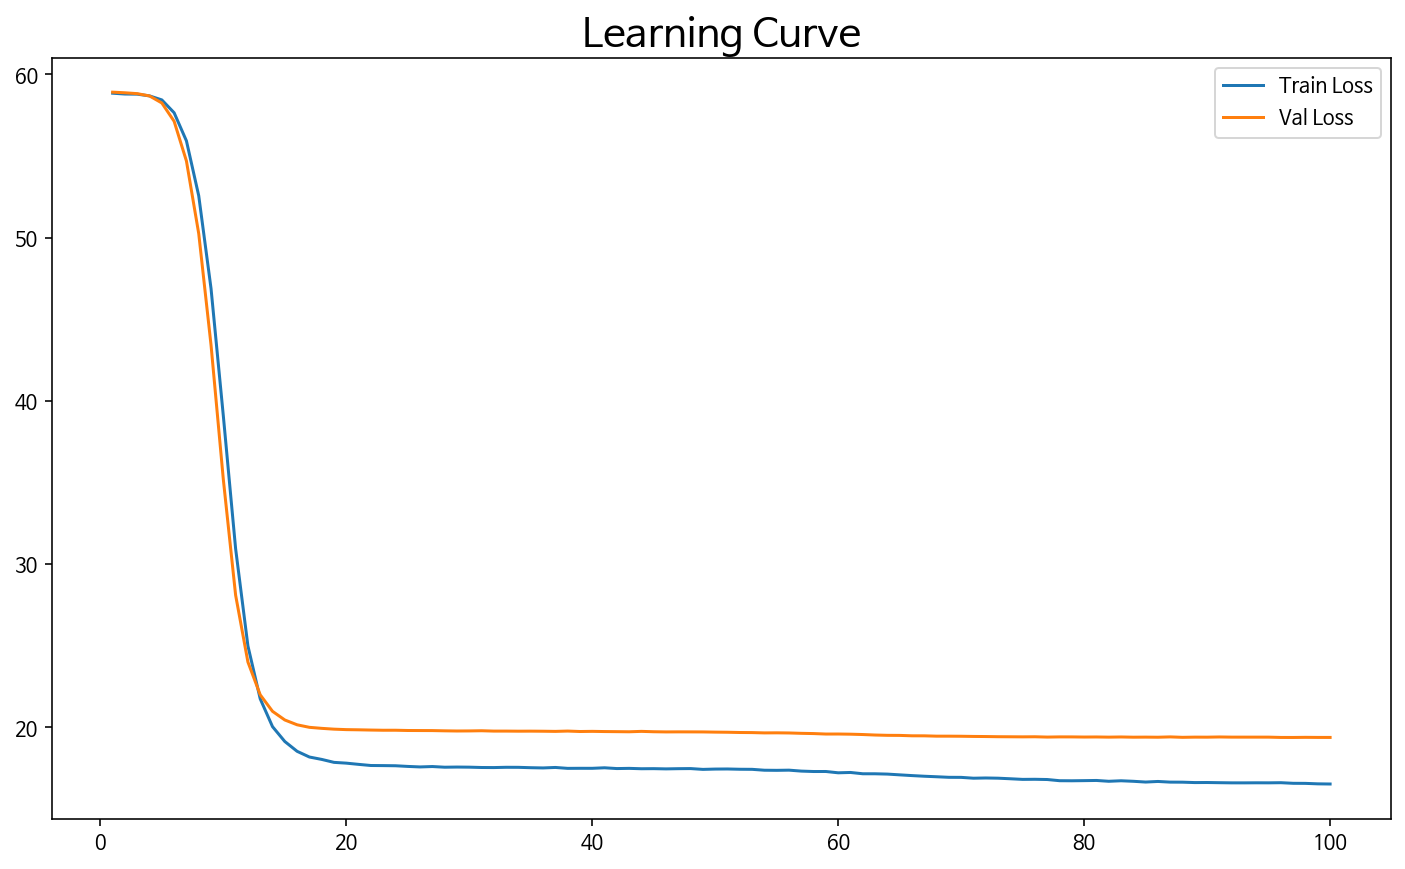

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = GMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li, test_small_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'광역시_GMF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['GMF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
model = GMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'광역시_GMF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['광역시도명_label']] = x['광역시도명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
df = pd.DataFrame(model.city_embedding.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

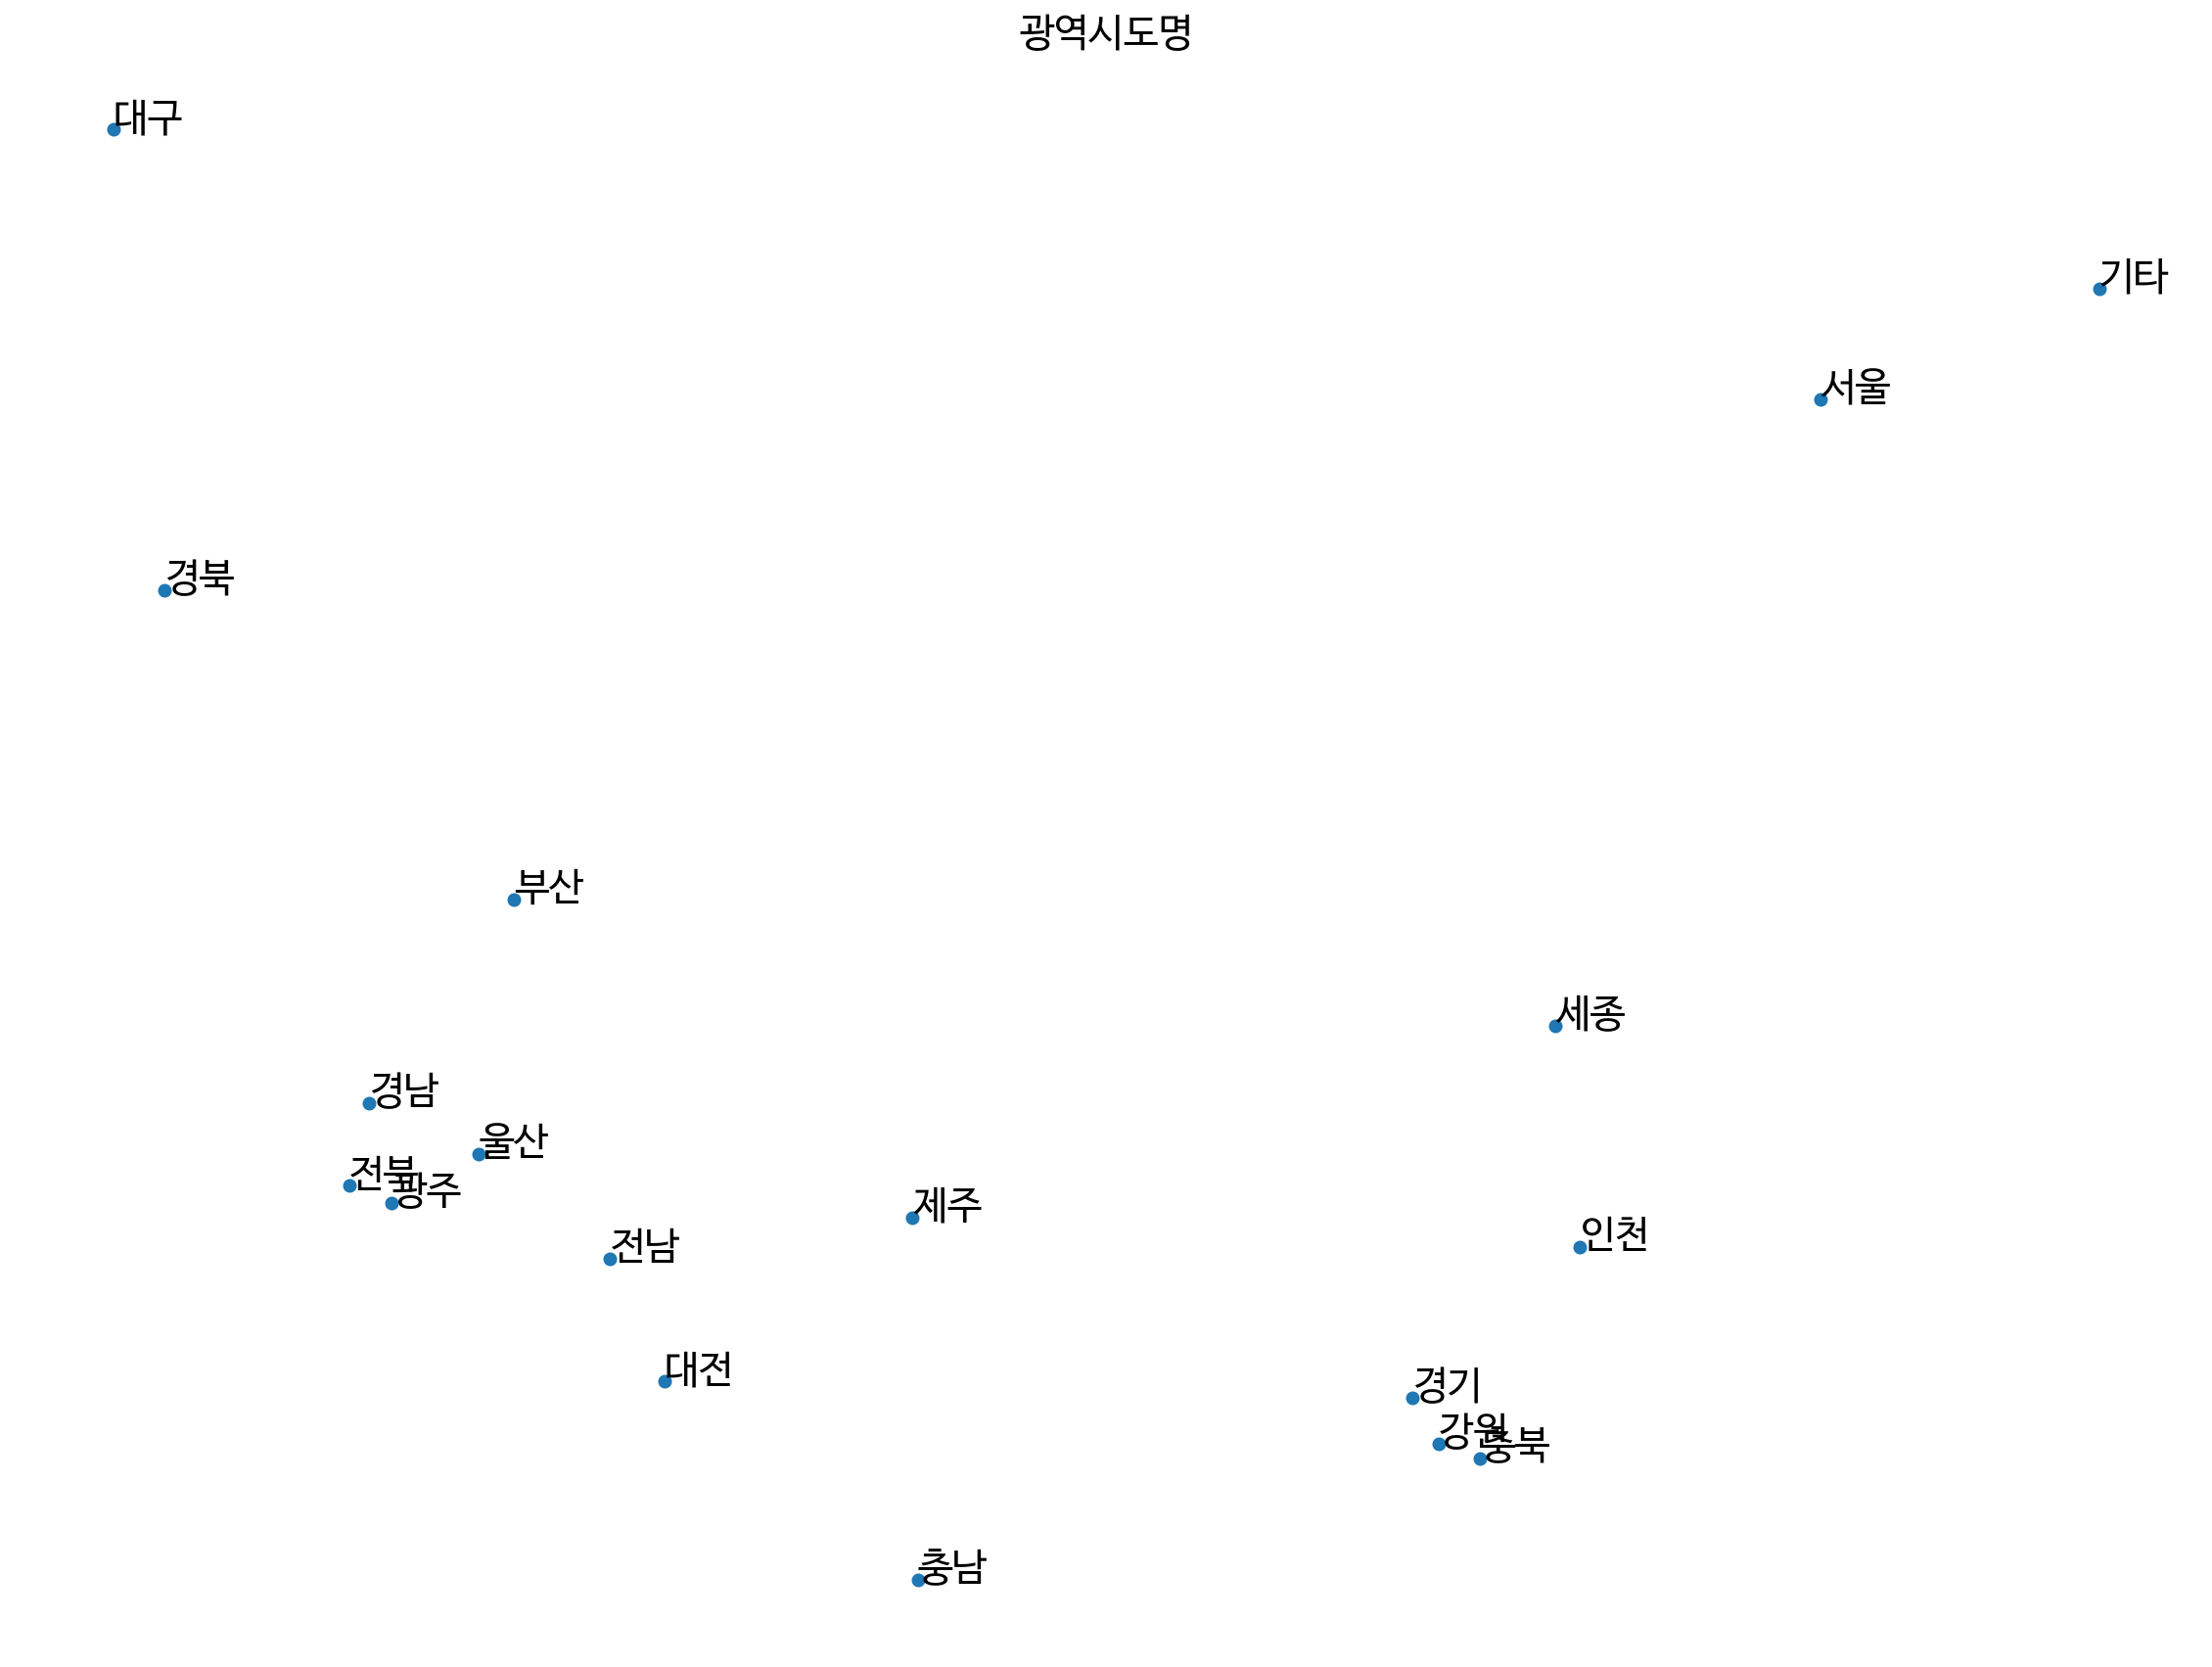

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('광역시도명', fontsize = 20)
ax.axis('off')
plt.show()

### (6) NCF


#### - 모델 정의


In [ ]:
class NCF(nn.Module):
  def __init__(self, city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num):
      super(NCF, self).__init__()

      self.city_embedding = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding = nn.Embedding(middle_sector_num, factor_num)
      self.small_sector_embedding = nn.Embedding(small_sector_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num * 4, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(256),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(128),
          nn.Linear(128, 1),
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding.weight, std=0.01)
      nn.init.normal_(self.small_sector_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, city_idx, big_sector_idx, middle_sector_idx, small_sector_idx):
      city_embedding = self.city_embedding(city_idx)
      big_sector_embedding = self.big_sector_embedding(big_sector_idx)
      middle_secto_embedding = self.middle_secto_embedding(middle_sector_idx)
      small_sector_embedding = self.small_sector_embedding(small_sector_idx)

      concat_vactors = torch.cat((city_embedding, big_sector_embedding, middle_secto_embedding, small_sector_embedding), -1)

      out = self.FC_layer(concat_vactors)

      return out.view(-1)

#### - 학습


In [ ]:
model = NCF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_small_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_small_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'광역시_NCF.pt')

  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 56.1673, Val Loss: 56.5229 

[EPOCH: 2], Train Loss: 52.4654, Val Loss: 52.2361 

[EPOCH: 3], Train Loss: 49.9684, Val Loss: 50.2317 

[EPOCH: 4], Train Loss: 47.5462, Val Loss: 47.8730 

[EPOCH: 5], Train Loss: 44.6488, Val Loss: 43.3105 

[EPOCH: 6], Train Loss: 40.7409, Val Loss: 40.5035 

[EPOCH: 7], Train Loss: 36.1584, Val Loss: 36.3727 

[EPOCH: 8], Train Loss: 31.1070, Val Loss: 30.7037 

[EPOCH: 9], Train Loss: 26.3592, Val Loss: 27.0012 

[EPOCH: 10], Train Loss: 21.7400, Val Loss: 23.2383 

[EPOCH: 11], Train Loss: 18.0429, Val Loss: 21.0971 

[EPOCH: 12], Train Loss: 15.5979, Val Loss: 19.9939 

[EPOCH: 13], Train Loss: 13.7721, Val Loss: 18.6665 

[EPOCH: 14], Train Loss: 12.7647, Val Loss: 18.8103 

[EPOCH: 15], Train Loss: 12.3127, Val Loss: 18.3761 

[EPOCH: 16], Train Loss: 11.7237, Val Loss: 18.4389 

[EPOCH: 17], Train Loss: 11.4609, Val Loss: 18.5685 

[EPOCH: 18], Train Loss: 11.2312, Val Loss: 18.4733 

[EPOCH: 19], Train Loss: 11.0239, Val

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 61, Best_Metric : 18.246545490933343


Text(0.5, 1.0, 'Learning Curve')

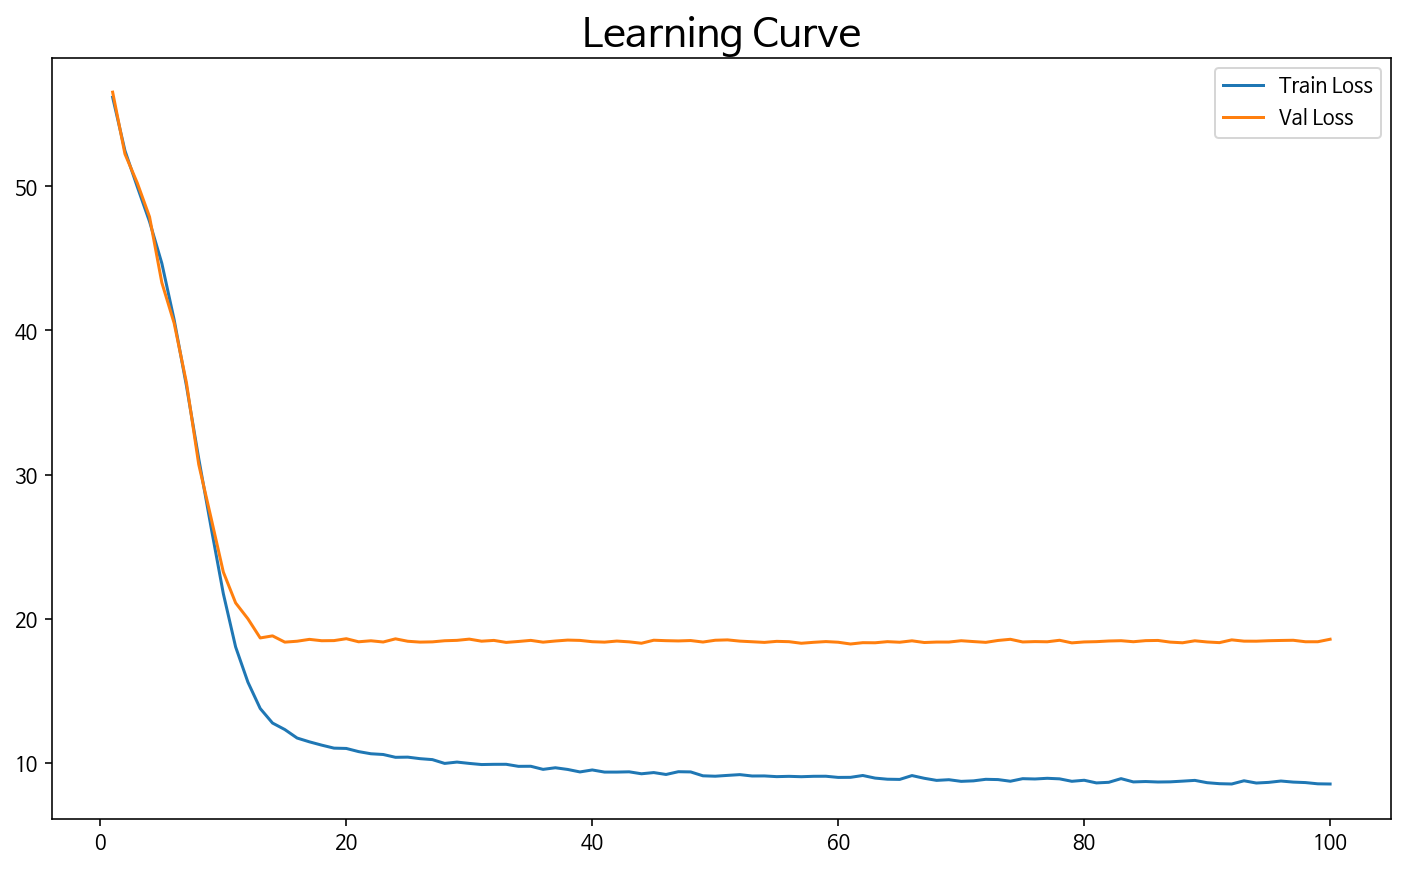

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = NCF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li, test_small_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'광역시_NCF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['NCF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
model = NCF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'광역시_NCF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['광역시도명_label']] = x['광역시도명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
df = pd.DataFrame(model.city_embedding.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

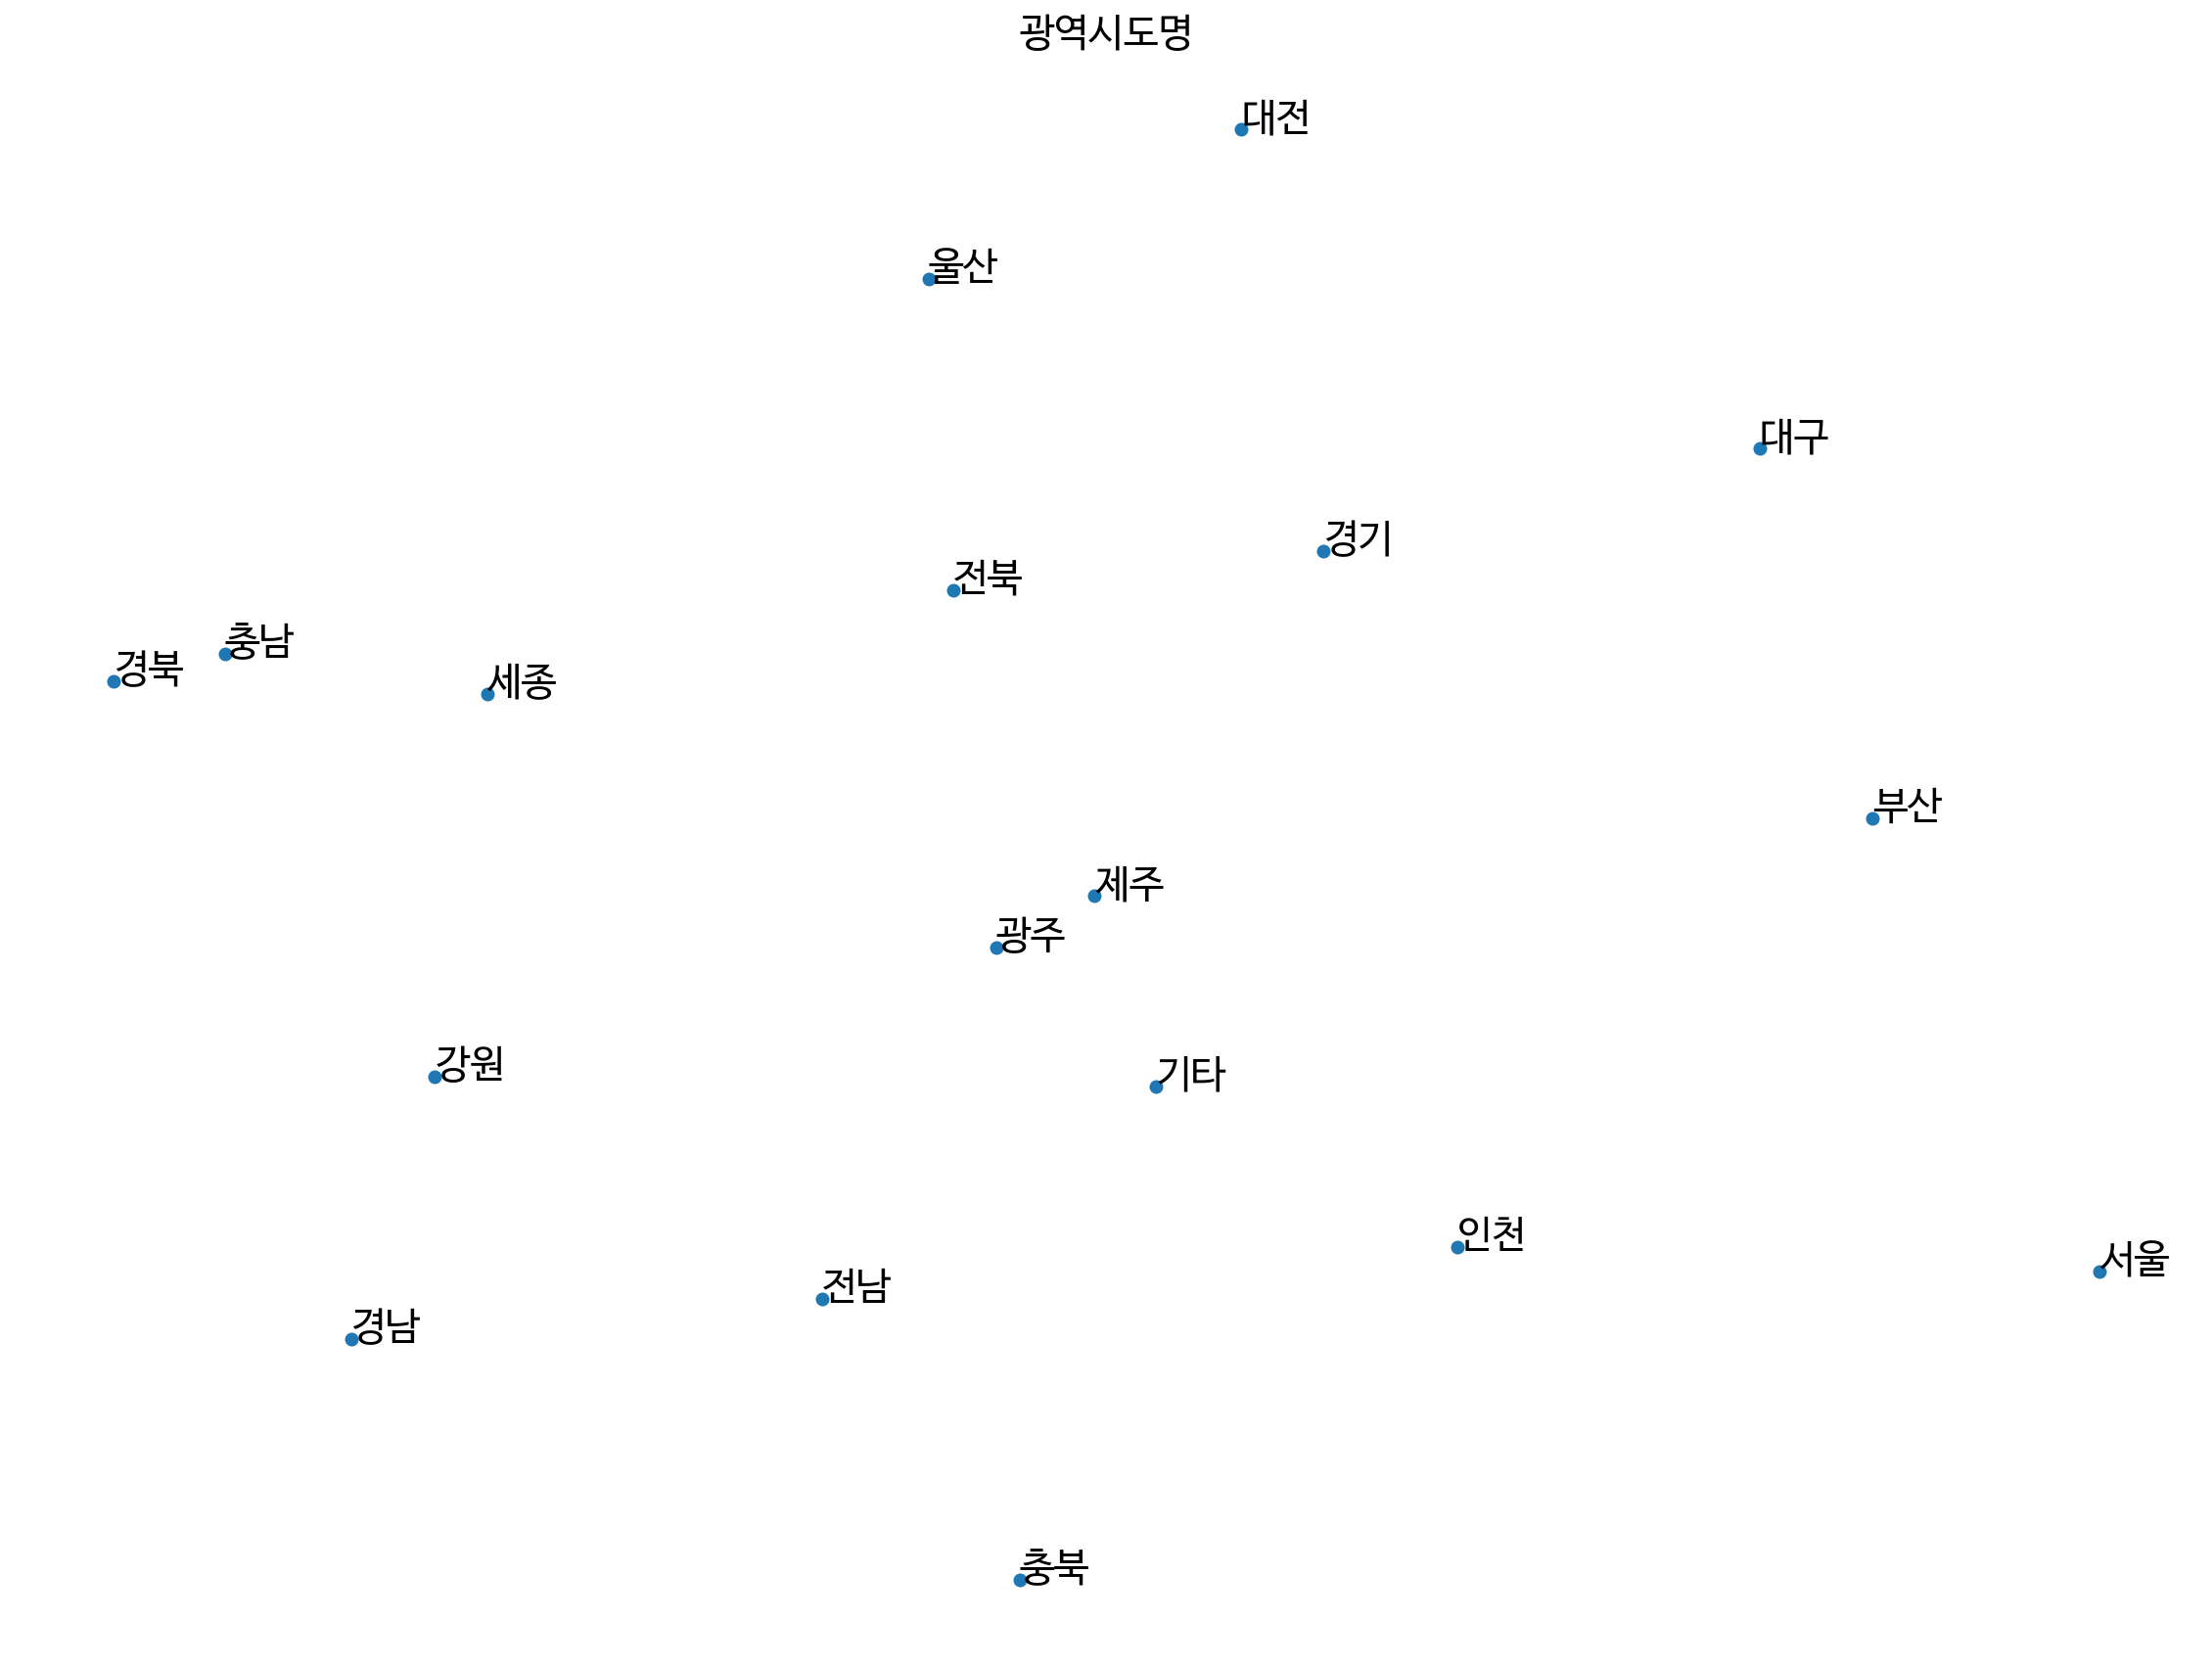

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('광역시도명', fontsize = 20)
ax.axis('off')
plt.show()

### (7) NMF


#### - 모델 정의


In [ ]:
class NMF(nn.Module):
  def __init__(self, city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num):
      super(NMF, self).__init__()

      self.city_embedding_gmf = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding_gmf = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding_gmf = nn.Embedding(middle_sector_num, factor_num)
      self.small_sector_embedding_gmf = nn.Embedding(small_sector_num, factor_num)

      self.city_embedding_ncf = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding_ncf = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding_ncf = nn.Embedding(middle_sector_num, factor_num)
      self.small_sector_embedding_ncf = nn.Embedding(small_sector_num, factor_num)

      # GMF_FC
      self.GMF_FC = nn.Sequential(
          nn.Linear(factor_num, factor_num)
      )

      # NCF_FC
      self.NCF_FC = nn.Sequential(
          nn.Linear(factor_num * 4, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(256),
          nn.Linear(256, 128),
          nn.ReLU()
      )
      
      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num + 128, 1)
      )

      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.small_sector_embedding_gmf.weight, std=0.01)

      nn.init.normal_(self.city_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.small_sector_embedding_ncf.weight, std=0.01)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)
      
      for m in self.GMF_FC:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.NCF_FC:
          if isinstance(m, nn.Linear):
              nn.init.kaiming_uniform_(m.weight)

  def forward(self, city_idx, big_sector_idx, middle_sector_idx, small_sector_idx):

      city_embedding_gmf = self.city_embedding_gmf(city_idx)
      big_sector_embedding_gmf = self.big_sector_embedding_gmf(big_sector_idx)
      middle_secto_embedding_gmf = self.middle_secto_embedding_gmf(middle_sector_idx)
      small_sector_embedding_gmf = self.small_sector_embedding_gmf(small_sector_idx)

      city_embedding_ncf = self.city_embedding_ncf(city_idx)
      big_sector_embedding_ncf = self.big_sector_embedding_ncf(big_sector_idx)
      middle_secto_embedding_ncf = self.middle_secto_embedding_ncf(middle_sector_idx)
      small_sector_embedding_ncf = self.small_sector_embedding_ncf(small_sector_idx)

      element_wise_product = (city_embedding_gmf * big_sector_embedding_gmf * middle_secto_embedding_gmf * small_sector_embedding_gmf)
      element_wise_product = self.GMF_FC(element_wise_product)

      concat_vactors = torch.cat((city_embedding_ncf, big_sector_embedding_ncf, middle_secto_embedding_ncf, small_sector_embedding_ncf), -1)
      concat_vactors = self.NCF_FC(concat_vactors)
      
      out = torch.cat((element_wise_product, concat_vactors), -1)
      out = self.FC_layer(out)

      return out.view(-1)

#### - 학습


In [ ]:
model = NMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_small_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_small_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'광역시_NMF.pt')

  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 50.6794, Val Loss: 45.9951 

[EPOCH: 2], Train Loss: 22.7027, Val Loss: 19.8925 

[EPOCH: 3], Train Loss: 18.5397, Val Loss: 19.7057 

[EPOCH: 4], Train Loss: 18.3900, Val Loss: 19.4807 

[EPOCH: 5], Train Loss: 17.9582, Val Loss: 19.3522 

[EPOCH: 6], Train Loss: 17.7321, Val Loss: 19.0844 

[EPOCH: 7], Train Loss: 17.7286, Val Loss: 19.2031 

[EPOCH: 8], Train Loss: 17.0863, Val Loss: 18.9734 

[EPOCH: 9], Train Loss: 16.6419, Val Loss: 18.6333 

[EPOCH: 10], Train Loss: 15.7442, Val Loss: 18.3442 

[EPOCH: 11], Train Loss: 14.6219, Val Loss: 18.2848 

[EPOCH: 12], Train Loss: 13.2695, Val Loss: 18.2233 

[EPOCH: 13], Train Loss: 11.9870, Val Loss: 18.2229 

[EPOCH: 14], Train Loss: 11.2867, Val Loss: 18.2435 

[EPOCH: 15], Train Loss: 10.7537, Val Loss: 18.2613 

[EPOCH: 16], Train Loss: 10.2055, Val Loss: 18.4374 

[EPOCH: 17], Train Loss: 9.5705, Val Loss: 18.3322 

[EPOCH: 18], Train Loss: 9.3446, Val Loss: 18.5729 

[EPOCH: 19], Train Loss: 9.0881, Val Lo

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 13, Best_Metric : 18.2228528562392


Text(0.5, 1.0, 'Learning Curve')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


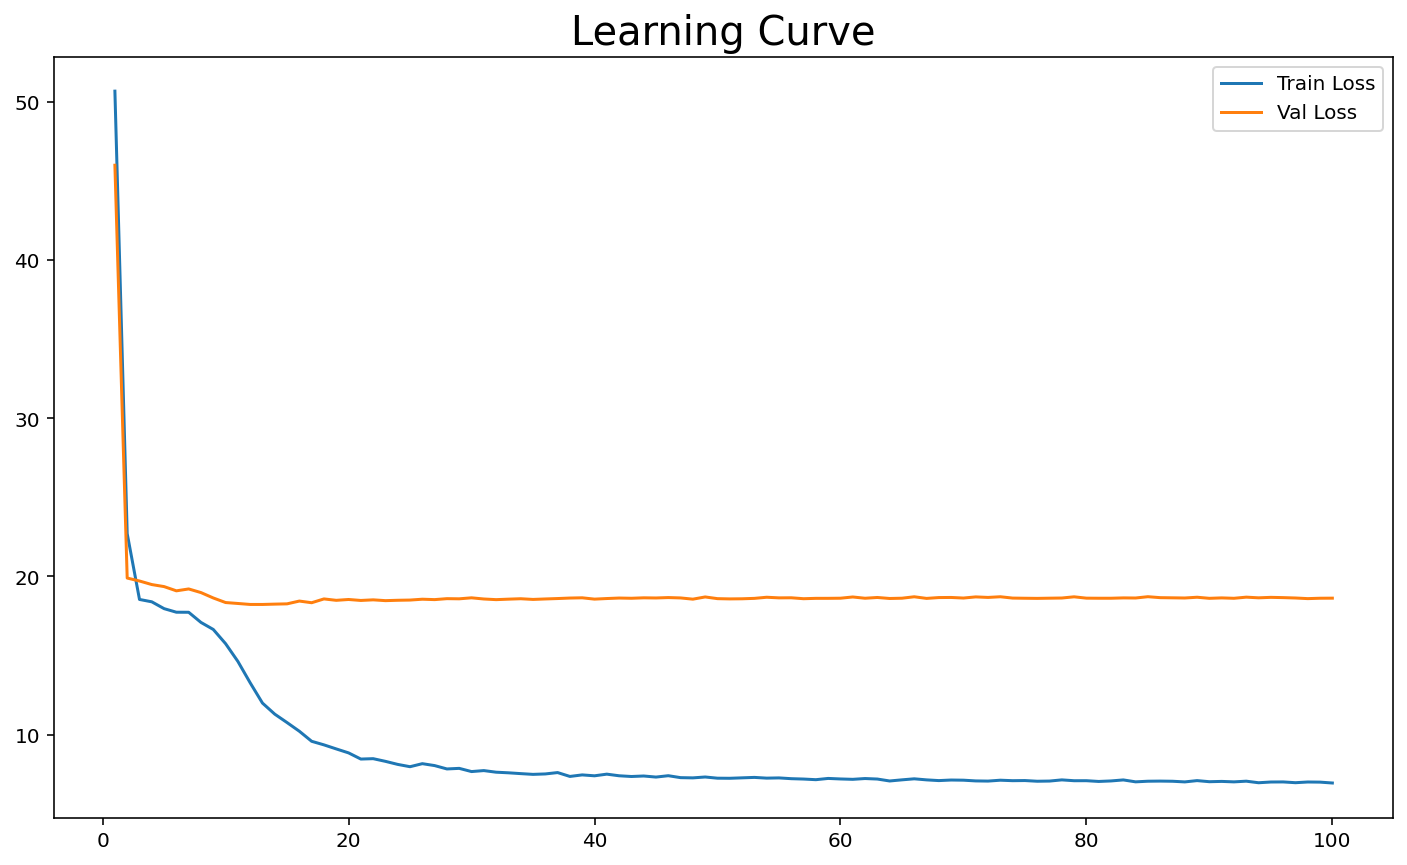

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = NMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li, test_small_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'광역시_NMF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['NMF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
model = NMF(city_num, big_sector_num, middle_sector_num, small_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'광역시_NMF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['광역시도명_label']] = x['광역시도명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
df = pd.DataFrame(model.city_embedding_gmf.weight.cpu().detach().numpy() * model.city_embedding_ncf.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

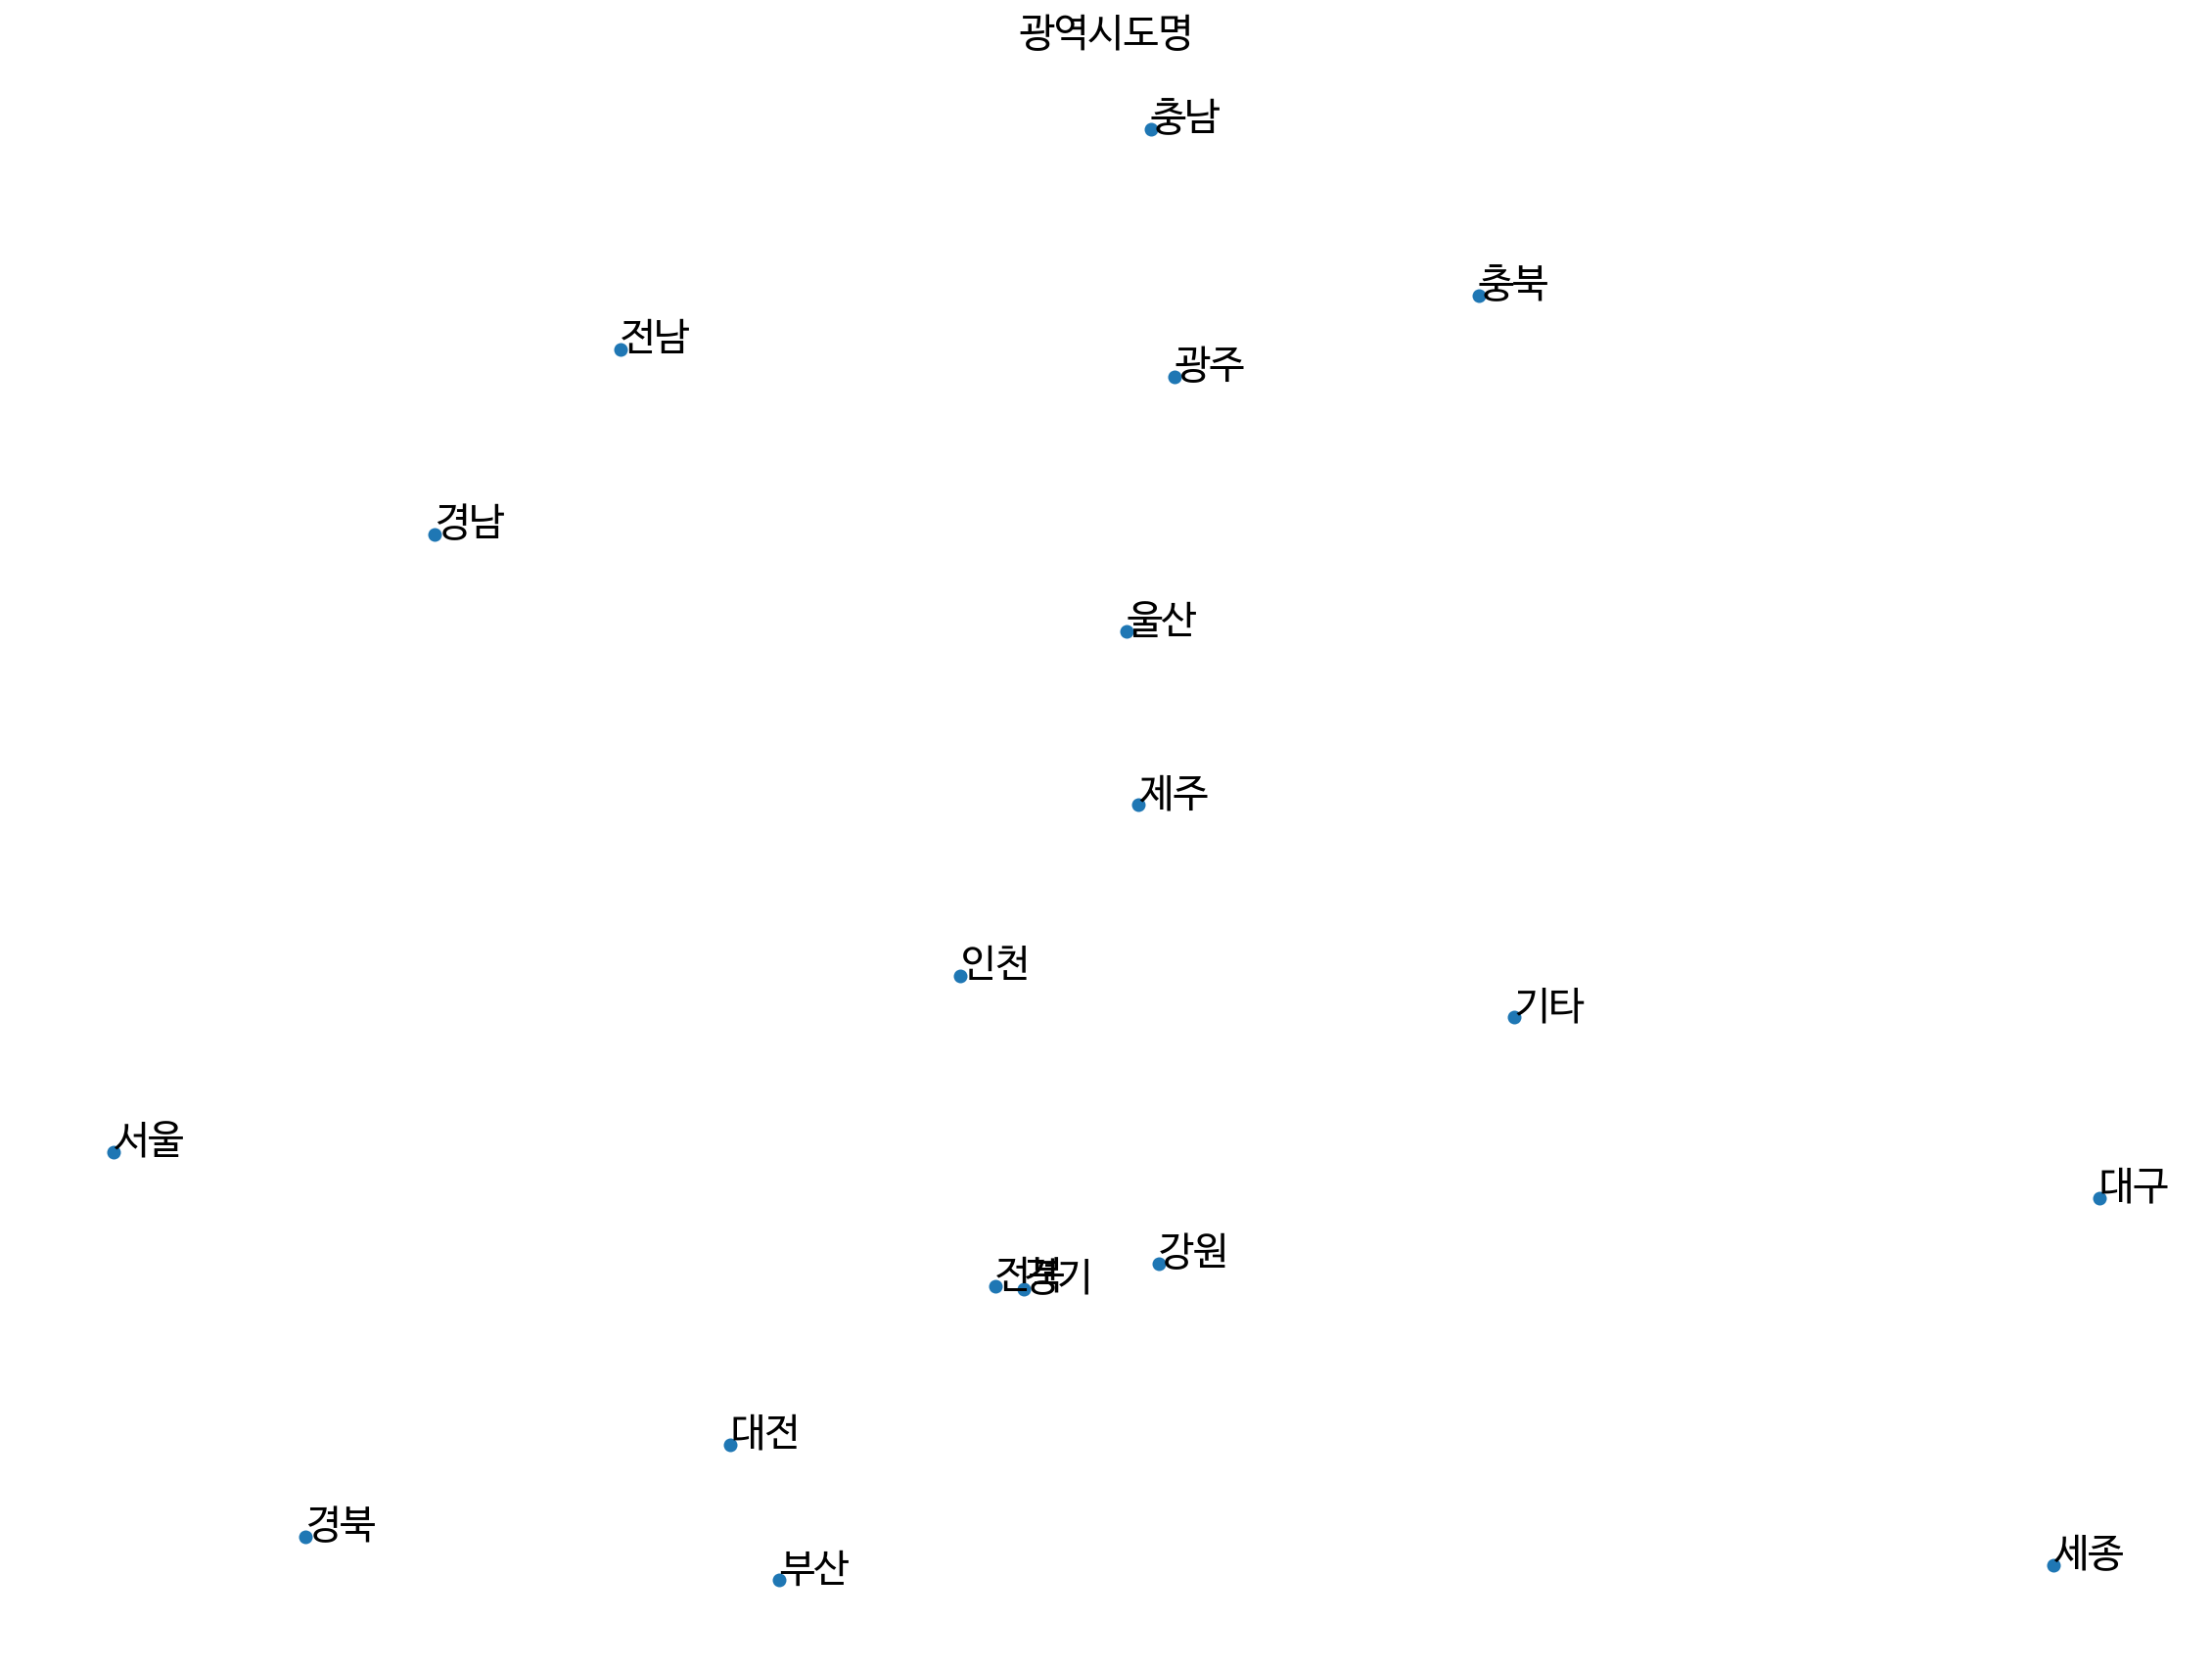

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('광역시도명', fontsize = 20)
ax.axis('off')
plt.show()

### (8) 결과

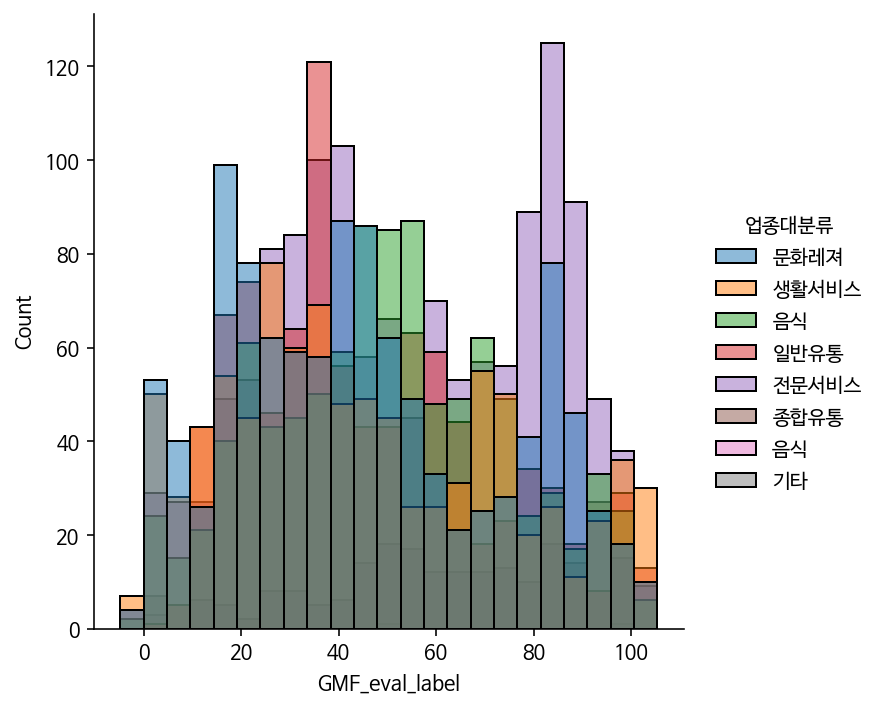

In [ ]:
sns.displot(data = Test_df, x = 'GMF_eval_label', hue = '업종대분류')

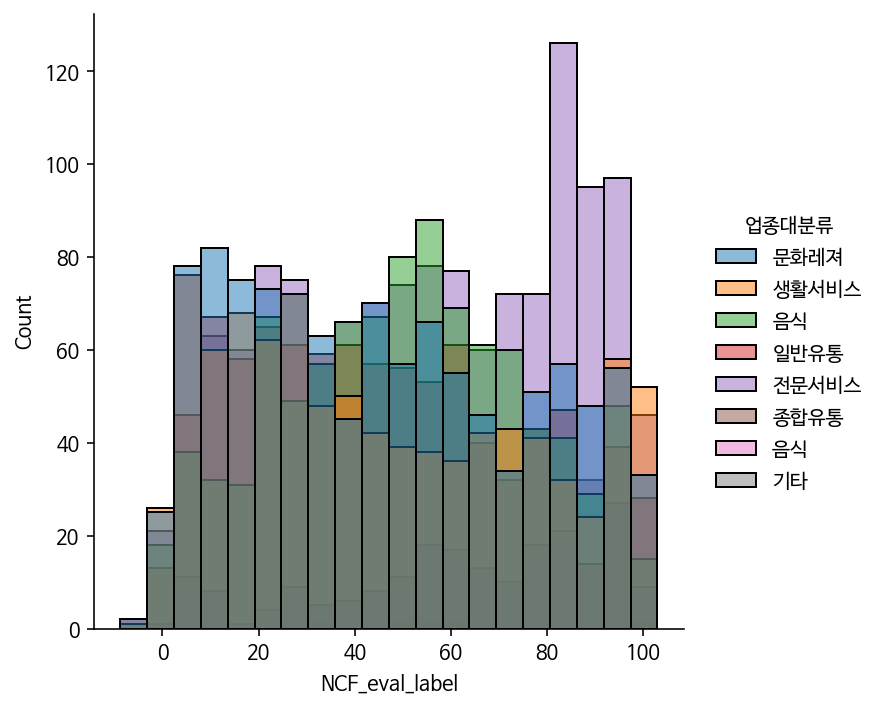

In [ ]:
sns.displot(data = Test_df, x = 'NCF_eval_label', hue = '업종대분류')

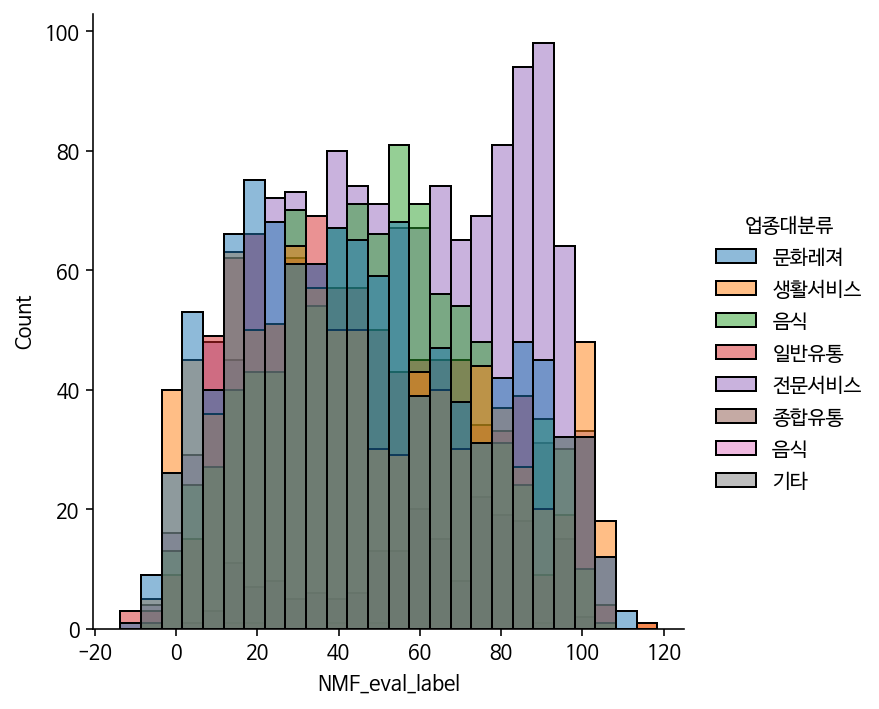

In [ ]:
sns.displot(data = Test_df, x = 'NMF_eval_label', hue = '업종대분류')

# 2.기업통계 금융보안원


## 2-1. 군집화를 활용한 Label 생성


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

!apt -qq -y install fonts-nanum                 # 상기 라이브러리에 폰트 설치 
                                                # 이하 기본 폰트가 되도록 설정
# 한글 폰트를 사용할 수 있게 만들어줌
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') # 그래프에서 한글 깨지는 현상 방지
plt.rc('axes', unicode_minus=False) # 그래프에서 마이너스 기호가 표시되도록
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


### (1) 데이터 불러오기


In [ ]:
PATHS = '/content/drive/MyDrive/금융데이터 공모전/Data/'

In [ ]:
df = pd.read_csv(PATHS + '지역별_Data_Input.csv')
df.head()

,기준년월,시도명,시군구명,동,업종대분류코드,업종중분류코드,업종대분류명,업종중분류명,기업구분코드,기업구분,업력구간코드,업력구간,총기업수,매출총액,매출평균액,매출중위액,영업이익총액,영업이익평균액,영업이익중위액,총종업원수,종업원평균수,평균임금_원,벤처기업수
0,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,4,소기업,2,2년이상 5년미만,1,6700.0,6700.0,6700.0,-6206.0,-6206.0,-6206.0,NaN,NaN,NaN,NaN
1,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,99,미분류,2,2년이상 5년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,99,미분류,5,5년이상 10년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12,강원,강릉시,교1동,A,A02,"농업, 임업 및 어업",임업,4,소기업,2,2년이상 5년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12,강원,강릉시,교1동,A,A02,"농업, 임업 및 어업",임업,4,소기업,5,5년이상 10년미만,1,470123.0,470123.0,470123.0,82867.0,82867.0,82867.0,NaN,NaN,NaN,NaN


In [ ]:
df2018 = df[df['기준년월'] == '2018-12']
df2019 = df[df['기준년월'] == '2019-12']
df2020 = df[df['기준년월'] == '2020-12']

### (2) 매출 classing


In [ ]:
def get_sales(li, x):

  if pd.isna(x) : return 0
  if x < 0 : return 1
  elif x < li[0] : return 2
  elif x < li[1] : return 3
  elif x < li[2] : return 4
  elif x < li[3] : return 5
  elif x < li[4] : return 6
  elif x < li[5] : return 7
  elif x < li[6] : return 8
  elif x < li[7] : return 9
  elif x < li[8] : return 10
  else: return 11

df2018_li = [df2018['매출총액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['매출총액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['매출총액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_매출총액'] = df2018['매출총액'].apply(lambda x : get_sales(df2018_li, x))
df2019['cat_매출총액'] = df2019['매출총액'].apply(lambda x : get_sales(df2019_li, x))
df2020['cat_매출총액'] = df2020['매출총액'].apply(lambda x : get_sales(df2020_li, x))

df2018_li = [df2018['매출평균액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['매출평균액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['매출평균액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_매출평균액'] = df2018['매출평균액'].apply(lambda x : get_sales(df2018_li, x))
df2019['cat_매출평균액'] = df2019['매출평균액'].apply(lambda x : get_sales(df2019_li, x))
df2020['cat_매출평균액'] = df2020['매출평균액'].apply(lambda x : get_sales(df2020_li, x))

df2018_li = [df2018['매출중위액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['매출중위액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['매출중위액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_매출중위액'] = df2018['매출중위액'].apply(lambda x : get_sales(df2018_li, x))
df2019['cat_매출중위액'] = df2019['매출중위액'].apply(lambda x : get_sales(df2019_li, x))
df2020['cat_매출중위액'] = df2020['매출중위액'].apply(lambda x : get_sales(df2020_li, x))

### (3) 영업이익 classing


In [ ]:
def get_Incomes(li, x):

  if pd.isna(x) : return 0
  elif x < li[0] : return 1
  elif x < li[1] : return 2
  elif x < li[2] : return 3
  elif x < li[3] : return 4
  elif x < li[4] : return 5
  elif x < li[5] : return 6
  elif x < li[6] : return 7
  elif x < li[7] : return 8
  elif x < li[8] : return 9
  else: return 10

df2018_li = [df2018['영업이익총액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['영업이익총액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['영업이익총액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_영업이익총액'] = df2018['영업이익총액'].apply(lambda x : get_Incomes(df2018_li, x))
df2019['cat_영업이익총액'] = df2019['영업이익총액'].apply(lambda x : get_Incomes(df2019_li, x))
df2020['cat_영업이익총액'] = df2020['영업이익총액'].apply(lambda x : get_Incomes(df2020_li, x))

df2018_li = [df2018['영업이익평균액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['영업이익평균액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['영업이익평균액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_영업이익평균액'] = df2018['영업이익평균액'].apply(lambda x : get_Incomes(df2018_li, x))
df2019['cat_영업이익평균액'] = df2019['영업이익평균액'].apply(lambda x : get_Incomes(df2019_li, x))
df2020['cat_영업이익평균액'] = df2020['영업이익평균액'].apply(lambda x : get_Incomes(df2020_li, x))

df2018_li = [df2018['영업이익중위액'].quantile(0.1 * i) for i in range(1, 10)]
df2019_li = [df2019['영업이익중위액'].quantile(0.1 * i) for i in range(1, 10)]
df2020_li = [df2020['영업이익중위액'].quantile(0.1 * i) for i in range(1, 10)]

df2018['cat_영업이익중위액'] = df2018['영업이익중위액'].apply(lambda x : get_Incomes(df2018_li, x))
df2019['cat_영업이익중위액'] = df2019['영업이익중위액'].apply(lambda x : get_Incomes(df2019_li, x))
df2020['cat_영업이익중위액'] = df2020['영업이익중위액'].apply(lambda x : get_Incomes(df2020_li, x))

### (4) 시각화


In [ ]:
all_df = pd.concat([df2018, df2019, df2020]).reset_index(drop = True)

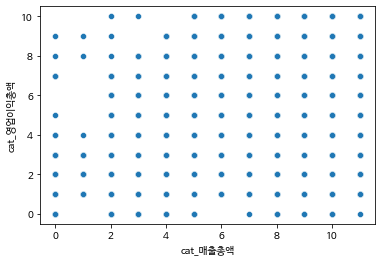

In [ ]:
sns.scatterplot(data = all_df, x = 'cat_매출총액', y = 'cat_영업이익총액')

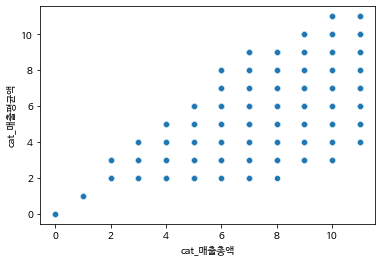

In [ ]:
sns.scatterplot(data = all_df, x = 'cat_매출총액', y = 'cat_매출평균액')

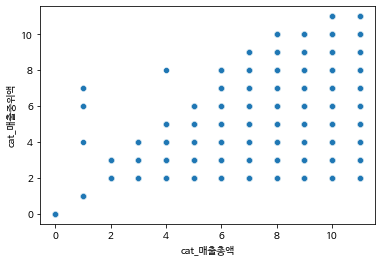

In [ ]:
sns.scatterplot(data = all_df, x = 'cat_매출총액', y = 'cat_매출중위액')

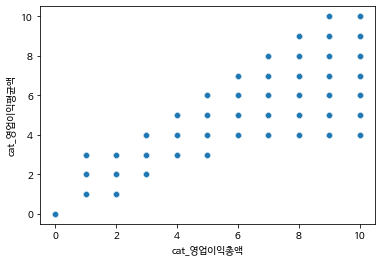

In [ ]:
sns.scatterplot(data = all_df, x = 'cat_영업이익총액', y = 'cat_영업이익평균액')

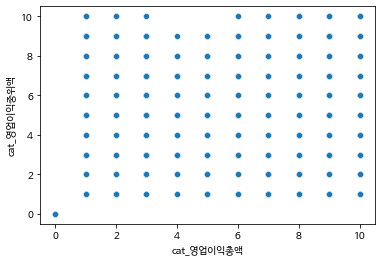

In [ ]:
sns.scatterplot(data = all_df, x = 'cat_영업이익총액', y = 'cat_영업이익중위액')

### (5) 최종 Label 생성


In [ ]:
cols = ['cat_비용총액', 'cat_비용평균액', 'cat_비용중위액',
        'cat_매출총액', 'cat_매출평균액', 'cat_매출중위액' ,
        'cat_영업이익총액', 'cat_영업이익평균액', 'cat_영업이익중위액',
        'cat_총종업원수', 'cat_종업원평균수', 'cat_평균임금_원', 
        '총기업수']

all_df['label'] =  all_df[cols[3]] + all_df[cols[4]] + all_df[cols[5]] + all_df[cols[6]] + all_df[cols[7]] + all_df[cols[8]]

In [ ]:
# 100점 만점을 기준으로 나눔

from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

year_li = all_df['기준년월'].unique()
_all_df = all_df.copy()

for year in year_li:
  idx_li = _all_df[_all_df['기준년월'] == year].index.tolist()
  _all_df.loc[idx_li, 'label'] = mm.fit_transform(_all_df.loc[idx_li, 'label'].values.reshape(-1, 1)) * 100

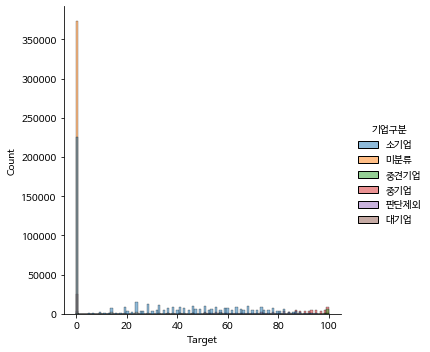

In [ ]:
sns.displot(data = _all_df, x = 'label', hue = '기업구분')

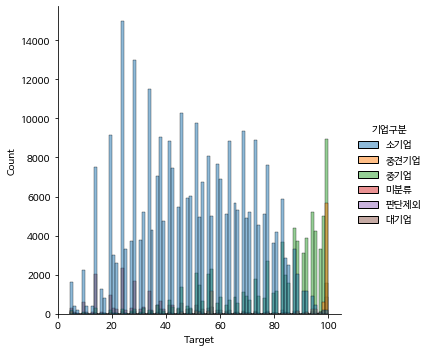

In [ ]:
sns.displot(data = _all_df[_all_df['label'] >= 1], x = 'label', hue = '기업구분')

## 2-2. 변동 계수(CV)를 고려한 Label 생성


### (1) 데이터 불러오기


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/금융데이터 공모전/Data/지역별_Data_Input.csv')
df.head()

,기준년월,시도명,시군구명,동,업종대분류코드,업종중분류코드,업종대분류명,업종중분류명,기업구분코드,기업구분,업력구간코드,업력구간,총기업수,매출총액,매출평균액,매출중위액,영업이익총액,영업이익평균액,영업이익중위액,총종업원수,종업원평균수,평균임금_원,벤처기업수
0,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,4,소기업,2,2년이상 5년미만,1,6700.0,6700.0,6700.0,-6206.0,-6206.0,-6206.0,NaN,NaN,NaN,NaN
1,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,99,미분류,2,2년이상 5년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,99,미분류,5,5년이상 10년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12,강원,강릉시,교1동,A,A02,"농업, 임업 및 어업",임업,4,소기업,2,2년이상 5년미만,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12,강원,강릉시,교1동,A,A02,"농업, 임업 및 어업",임업,4,소기업,5,5년이상 10년미만,1,470123.0,470123.0,470123.0,82867.0,82867.0,82867.0,NaN,NaN,NaN,NaN


### (2) 영업이익중위액을 활용한 변동계수(CV) 함수
: 시군구 및 기업구분과 업종대분류명 및 기업구문에 따른 변동계수 산출


In [ ]:
def sigun_cv(df):
    for s in tqdm(list(df['시군구명'].unique())):
        for c in list(df['기업구분'].unique()):
            df.loc[(df['시군구명']==s) & (df['기업구분']==c),'시군구_CV'] = np.std(df[(df['시군구명']==s) & (df['기업구분']==c)]['영업이익중위액']) / (np.mean(df[(df['시군구명']==s) & (df['기업구분']==c)]['영업이익중위액'])+ sys.float_info.epsilon)
    df.시군구_CV = df.시군구_CV.astype(float)
    return df   

def upjong_cv(df):
    for s in tqdm(list(df['업종대분류명'].unique())):
        for c in list(df['기업구분'].unique()):
            df.loc[(df['업종대분류명']==s) & (df['기업구분']==c),'업종대분류명_CV'] = np.std(df[(df['업종대분류명']==s) & (df['기업구분']==c)]['영업이익중위액']) /  (np.mean(df[(df['업종대분류명']==s) & (df['기업구분']==c)]['영업이익중위액'])+ sys.float_info.epsilon)
    df.업종대분류명_CV = df.업종대분류명_CV.astype(float)
    return df

### (3) 분위수를 활용한 점수 산출을 위해 각 지표에 따른 기준점 도출 함수
: 기업구분에 따른 영업이익중위액, 시군구별 영업이익중위액 변동계수, 업종대분류명별 영업이익중위액 변동계수

In [ ]:
def get_quantile_sigun(df, col):
  ret_quantile = {}
  for i in range(1, 10):
    ret_li = df.groupby([col,'기업구분']).quantile(0.1 * i)['시군구_CV']
    for key, val in zip(ret_li.index, ret_li.values):
      if i == 1:
        ret_quantile[key] = [val]
      else:
        ret_quantile[key] += [val]

  return ret_quantile

def get_quantile_upjong(df, col):
    ret_quantile = {}
    for i in range(1, 10):
        ret_li = df.groupby([col,'기업구분']).quantile(0.1 * i)['업종대분류명_CV']
        for key, val in zip(ret_li.index, ret_li.values):
            if i == 1:
                ret_quantile[key] = [val]
            else:
                ret_quantile[key] += [val]

    return ret_quantile 

def get_quantile(df, col):
  ret_quantile = {}
  for i in range(1, 10):
    ret_li = df.groupby([col,'기업구분']).quantile(0.1 * i)['영업이익중위액']
    for key, val in zip(ret_li.index, ret_li.values):
      if i == 1:
        ret_quantile[key] = [val]
      else:
        ret_quantile[key] += [val]

  return ret_quantile

### (4) 산출한 기준점을 바탕으로 점수 부여 함수
 10분위수로 나누어 점수가 높을 수록 해당 데이터가 긍정적인 것을 나타냄

In [ ]:
def get_CV(quantile_li, col, df,cv_col):
  li = quantile_li[tuple(df[[col,'기업구분']])]
  x = df[cv_col]
  if x < li[0] : return 10
  elif x < li[1] : return 9
  elif x < li[2] : return 8
  elif x < li[3] : return 7
  elif x < li[4] : return 6
  elif x < li[5] : return 5
  elif x < li[6] : return 4
  elif x < li[7] : return 3
  elif x < li[8] : return 2
  else: return 1
 
def get_Incomes(quantile_li, col, df):
  li = quantile_li[tuple(df[[col,'기업구분']])]
  x = df['영업이익중위액']
  if x < li[0] : return 1
  elif x < li[1] : return 2
  elif x < li[2] : return 3
  elif x < li[3] : return 4
  elif x < li[4] : return 5
  elif x < li[5] : return 6
  elif x < li[6] : return 7
  elif x < li[7] : return 8
  elif x < li[8] : return 9
  else: return 10

### (5) 데이터 전처리
: Train 데이터는 영업이익중위액이 존재하는 데이터로, Test 데이터는 영업이익중위액이 없는 데이터로 나누어 전처리를 진행

In [ ]:
df = df.fillna({"시군구명": '세종시'}) # 세종특별시는 시군구명이 null 값으로 되어 있어 채움
df = df[~(df['업종대분류명'] == '가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산활동')]

Train = df[~(df['영업이익중위액'].isna())].reset_index(drop = True)
Test = df[df['영업이익중위액'].isna()].reset_index(drop = True)

mm = MinMaxScaler()
Train.loc[Train['기준년월'] == '2018-12','영업이익중위액'] = mm.fit_transform(Train[Train['기준년월'] == '2018-12'][['영업이익중위액']])
Train.loc[Train['기준년월'] == '2019-12','영업이익중위액'] = mm.fit_transform(Train[Train['기준년월'] == '2019-12'][['영업이익중위액']])
Train.loc[Train['기준년월'] == '2020-12','영업이익중위액'] = mm.fit_transform(Train[Train['기준년월'] == '2020-12'][['영업이익중위액']])

Train_2018 = Train[Train['기준년월'] == '2018-12']
Train_2019 = Train[Train['기준년월'] == '2019-12']
Train_2020 = Train[Train['기준년월'] == '2020-12']
Train_2020 = Train_2020[~(Train_2020['업종중분류명'] == '국제 및 외국기관')]

### (6) Label 생성을 위한 함수 적용


In [ ]:
eps = sys.float_info.epsilon

comp = df['기업구분'].unique()
sigun = df['시군구명'].unique()
upjong = df['업종대분류명'].unique()

sigun_cv(Train_2018)
sigun_cv(Train_2019)
sigun_cv(Train_2020)

upjong_cv(Train_2018)
upjong_cv(Train_2019)
upjong_cv(Train_2020)

city_2018_CV_quantile = get_quantile_sigun(Train_2018, '시군구명')
city_2019_CV_quantile = get_quantile_sigun(Train_2019, '시군구명')
city_2020_CV_quantile = get_quantile_sigun(Train_2020, '시군구명')

sector_2018_CV_quantile = get_quantile_upjong(Train_2018, '업종대분류명')
sector_2019_CV_quantile = get_quantile_upjong(Train_2019, '업종대분류명')
sector_2020_CV_quantile = get_quantile_upjong(Train_2020, '업종대분류명')

city_2018_quantile = get_quantile(Train_2018, '시군구명')
city_2019_quantile = get_quantile(Train_2019, '시군구명')
city_2020_quantile = get_quantile(Train_2020, '시군구명')

sector_2018_quantile = get_quantile(Train_2018, '업종대분류명')
sector_2019_quantile = get_quantile(Train_2019, '업종대분류명')
sector_2020_quantile = get_quantile(Train_2020, '업종대분류명')

Train_2018['cat_시군구_CV'] = Train_2018.apply(lambda x : get_CV(city_2018_CV_quantile, '시군구명', x,'시군구_CV'), axis = 1)
Train_2019['cat_시군구_CV'] = Train_2019.apply(lambda x : get_CV(city_2019_CV_quantile, '시군구명', x,'시군구_CV'), axis = 1)
Train_2020['cat_시군구_CV'] = Train_2020.apply(lambda x : get_CV(city_2020_CV_quantile, '시군구명', x,'시군구_CV'), axis = 1)

Train_2018['cat_업종_CV'] = Train_2018.apply(lambda x : get_CV(sector_2018_CV_quantile, '업종대분류명', x,'업종대분류명_CV'), axis = 1)
Train_2019['cat_업종_CV'] = Train_2019.apply(lambda x : get_CV(sector_2019_CV_quantile, '업종대분류명', x,'업종대분류명_CV'), axis = 1)
Train_2020['cat_업종_CV'] = Train_2020.apply(lambda x : get_CV(sector_2020_CV_quantile, '업종대분류명', x,'업종대분류명_CV'), axis = 1)

Train_2018['cat_시군구_영업이익중위액'] = Train_2018.apply(lambda x : get_Incomes(city_2018_quantile, '시군구명', x), axis = 1)
Train_2019['cat_시군구_영업이익중위액'] = Train_2019.apply(lambda x : get_Incomes(city_2019_quantile, '시군구명', x), axis = 1)
Train_2020['cat_시군구_영업이익중위액'] = Train_2020.apply(lambda x : get_Incomes(city_2020_quantile, '시군구명', x), axis = 1)

Train_2018['cat_업종_영업이익중위액'] = Train_2018.apply(lambda x : get_Incomes(sector_2018_quantile, '업종대분류명', x), axis = 1)
Train_2019['cat_업종_영업이익중위액'] = Train_2019.apply(lambda x : get_Incomes(sector_2019_quantile, '업종대분류명', x), axis = 1)
Train_2020['cat_업종_영업이익중위액'] = Train_2020.apply(lambda x : get_Incomes(sector_2020_quantile, '업종대분류명', x), axis = 1)

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

### (7) 업종대분류와 시군구 점수를 합산한 최종 Label 생성
: 100점을 기준으로 점수 산출

In [ ]:
Train_2018['label_시군구_영업이익중위액'] = Train_2018['cat_시군구_영업이익중위액'] * Train_2018['cat_시군구_CV']
Train_2019['label_시군구_영업이익중위액'] = Train_2019['cat_시군구_영업이익중위액'] * Train_2019['cat_시군구_CV']
Train_2020['label_시군구_영업이익중위액'] = Train_2020['cat_시군구_영업이익중위액'] * Train_2020['cat_시군구_CV']

Train_2018['label_업종_영업이익중위액'] = Train_2018['cat_업종_영업이익중위액'] * Train_2018['cat_업종_CV']
Train_2019['label_업종_영업이익중위액'] = Train_2019['cat_업종_영업이익중위액'] * Train_2019['cat_업종_CV']
Train_2020['label_업종_영업이익중위액'] = Train_2020['cat_업종_영업이익중위액'] * Train_2020['cat_업종_CV']

Train_2018['label'] = Train_2018['label_업종_영업이익중위액'] + Train_2018['label_시군구_영업이익중위액']
Train_2019['label'] = Train_2019['label_업종_영업이익중위액'] + Train_2019['label_시군구_영업이익중위액']
Train_2020['label'] = Train_2020['label_업종_영업이익중위액'] + Train_2020['label_시군구_영업이익중위액']

Train_2018['label'] = mm.fit_transform(Train_2018[['label']]) * 100
Train_2019['label'] = mm.fit_transform(Train_2019[['label']]) * 100
Train_2020['label'] = mm.fit_transform(Train_2020[['label']]) * 100

Train_2018['label_시군구_영업이익중위액'] = mm.fit_transform(Train_2018[['label_시군구_영업이익중위액']])
Train_2019['label_시군구_영업이익중위액'] = mm.fit_transform(Train_2019[['label_시군구_영업이익중위액']])
Train_2020['label_시군구_영업이익중위액'] = mm.fit_transform(Train_2020[['label_시군구_영업이익중위액']])

Train_2018['label_업종_영업이익중위액'] = mm.fit_transform(Train_2018[['label_업종_영업이익중위액']])
Train_2019['label_업종_영업이익중위액'] = mm.fit_transform(Train_2019[['label_업종_영업이익중위액']])
Train_2020['label_업종_영업이익중위액'] = mm.fit_transform(Train_2020[['label_업종_영업이익중위액']])

all_Train = pd.concat([Train_2018, Train_2019, Train_2020]).reset_index(drop = True)

In [ ]:
all_Train.head()

,기준년월,시도명,시군구명,동,업종대분류코드,업종중분류코드,업종대분류명,업종중분류명,기업구분코드,기업구분,업력구간코드,업력구간,총기업수,매출총액,매출평균액,매출중위액,영업이익총액,영업이익평균액,영업이익중위액,총종업원수,종업원평균수,평균임금_원,벤처기업수,시군구_CV,업종대분류명_CV,cat_시군구_CV,cat_업종_CV,cat_시군구_영업이익중위액,cat_업종_영업이익중위액,label_시군구_영업이익중위액,label_업종_영업이익중위액,label
0,2018-12,강원,강릉시,교1동,A,A01,"농업, 임업 및 어업",농업,4,소기업,2,2년이상 5년미만,1,6700.0,6700.0,6700.0,-6206.0,-6206.0,0.415674,NaN,NaN,NaN,NaN,0.00001,0.000010,1,1,3,4,0.222222,0.333333,27.777778
1,2018-12,강원,강릉시,교1동,A,A02,"농업, 임업 및 어업",임업,4,소기업,5,5년이상 10년미만,1,470123.0,470123.0,470123.0,82867.0,82867.0,0.415675,NaN,NaN,NaN,NaN,0.00001,0.000010,1,1,8,8,0.777778,0.777778,77.777778
2,2018-12,강원,강릉시,교1동,A,A03,"농업, 임업 및 어업",어업,4,소기업,10,10년이상 20년미만,1,211383.0,211383.0,211383.0,30630.0,30630.0,0.415675,NaN,NaN,NaN,NaN,0.00001,0.000010,1,1,6,7,0.555556,0.666667,61.111111
3,2018-12,강원,강릉시,교1동,B,B07,광업,비금속광물 광업; 연료용 제외,4,소기업,10,10년이상 20년미만,2,1364817.0,1364817.0,1364817.0,629123.0,629123.0,0.415683,4.0,4.0,27518667.0,NaN,0.00001,0.000016,1,1,10,10,1.000000,1.000000,100.000000
4,2018-12,강원,강릉시,교1동,B,B07,광업,비금속광물 광업; 연료용 제외,4,소기업,20,20년이상 30년미만,1,1007550.0,1007550.0,1007550.0,104900.0,104900.0,0.415676,3.0,3.0,32783111.0,NaN,0.00001,0.000016,1,1,9,6,0.888889,0.555556,72.222222


### (8) 데이터 저장


In [ ]:
all_Train.to_csv('/content/drive/MyDrive/금융데이터 공모전/Data/지역별통계데이터(기업)_Train.csv', index=0)
Test.to_csv('/content/drive/MyDrive/금융데이터 공모전/Data/지역별통계데이터(기업)_Test.csv', index=0)

## 2-3. Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings("ignore")

In [ ]:
%config InlineBackend.figure_format = 'retina'  # 레티나 디스플레이 지원을 통해 한글을 선명하게 보여줌
 
!apt -qq -y install fonts-nanum                 # 상기 라이브러리에 폰트 설치 
                                                # 이하 기본 폰트가 되도록 설정
# 한글 폰트를 사용할 수 있게 만들어줌
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


### (1) 데이터 불러오기


In [ ]:
PATHS = '/content/drive/MyDrive/금융데이터 공모전/Data/'
MODEL_DIR = '/content/drive/MyDrive/금융데이터 공모전/Model/'

In [ ]:
Train_df = pd.read_csv(PATHS + '지역별통계데이터(기업)_Train.csv')
Test_df = pd.read_csv(PATHS + '지역별통계데이터(기업)_Test.csv')

### (2) 라벨인코딩
: 임베딩을 위한 리벨 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cat_cols = ['시군구명', '기업구분', '업종대분류명', '업종중분류명']
all_df = pd.concat([ Train_df[cat_cols], Test_df[cat_cols] ]).reset_index(drop = True)

for col in cat_cols:
  all_df[f'{col}_label'] = encoder.fit_transform(all_df[col].values)
  Train_df[f'{col}_label'] = encoder.transform(Train_df[col].values)
  Test_df[f'{col}_label'] = encoder.transform(Test_df[col].values)

### (3) 데이터 스플릿
: Train과 Val 데이터 분리

In [ ]:
Train = Train_df[Train_df['기준년월'] != '2020-12']
Val = Train_df[Train_df['기준년월'] == '2020-12']

### (4) 모델 기본 설정
: Model에 input으로 넣기 위한 데이터 전처리, 데이터 로더 정의, 모델 기본 설정, 학습 / 평가 / 예측 함수 정의

In [ ]:
train_city_idx_li = Train['시군구명_label'].tolist()
train_company_idx_li = Train['기업구분_label'].tolist()
train_big_sector_idx_li = Train['업종대분류명_label'].tolist()
train_middle_sector_idx_li = Train['업종중분류명_label'].tolist()
train_label_li = Train['label'].astype(float).tolist()

val_city_idx_li = Val['시군구명_label'].tolist()
val_company_idx_li = Val['기업구분_label'].tolist()
val_big_sector_idx_li = Val['업종대분류명_label'].tolist()
val_middle_sector_idx_li = Val['업종중분류명_label'].tolist()
val_label_li = Val['label'].astype(float).tolist()

test_city_idx_li = Test_df['시군구명_label'].tolist()
test_company_idx_li = Test_df['기업구분_label'].tolist()
test_big_sector_idx_li = Test_df['업종대분류명_label'].tolist()
test_middle_sector_idx_li = Test_df['업종중분류명_label'].tolist()

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class GMFData(Dataset):
    def __init__(self, city_idx_li, company_idx_li, big_sector_idx_li, middle_sector_idx_li, label_li = None):
      super(GMFData, self).__init__()
      self._city_idx_li = city_idx_li
      self._company_idx_li = company_idx_li
      self._big_sector_idx_li = big_sector_idx_li
      self._middle_sector_idx_li = middle_sector_idx_li
      self._label_li = label_li

    def __len__(self):
      return len(self._city_idx_li)

    def __getitem__(self, idx):
      if self._label_li is None:

        city = self._city_idx_li[idx]
        company = self._company_idx_li[idx]
        big_sector = self._big_sector_idx_li[idx]
        middle_sector = self._middle_sector_idx_li[idx]
        return city, company, big_sector, middle_sector

      else:
        city = self._city_idx_li[idx]
        company = self._company_idx_li[idx]
        big_sector = self._big_sector_idx_li[idx]
        middle_sector = self._middle_sector_idx_li[idx]
        label = self._label_li[idx]

        return city, company, big_sector, middle_sector, label

In [ ]:
city_num = all_df['시군구명_label'].max() + 1
company_num = all_df['기업구분_label'].max() + 1
big_sector_num = all_df['업종대분류명_label'].max() + 1
middle_sector_num = all_df['업종중분류명_label'].max() + 1
factor_num = 64

In [ ]:
BATCH_SIZE = 256
EPOCHS = 100

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for city, company, big_sector, middle_sector, label in train_loader:
    city = city.to(DEVICE)
    company = company.to(DEVICE)
    big_sector = big_sector.to(DEVICE)
    middle_sector = middle_sector.to(DEVICE)
    label = label.to(DEVICE)
    label = label.type(torch.DoubleTensor)

    optimizer.zero_grad()

    output = model(city, company, big_sector, middle_sector)
    output = output.type(torch.DoubleTensor)

    loss = criterion(output, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  return train_loss

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0

  with torch.no_grad():
    for city, company, big_sector, middle_sector, label in test_loader:
      city = city.to(DEVICE)
      company = company.to(DEVICE)
      big_sector = big_sector.to(DEVICE)
      middle_sector = middle_sector.to(DEVICE)
      label = label.to(DEVICE)
      label = label.type(torch.DoubleTensor)

      output = model(city, company, big_sector, middle_sector)
      output = output.type(torch.DoubleTensor)

      loss = criterion(output, label)

      test_loss += loss.item()

  test_loss /= len(test_loader)

  return test_loss

In [ ]:
def get_test_label(model, test_loader):
  model.eval()
  output_li = []

  with torch.no_grad():
    for city, company, big_sector, middle_sector in test_loader:
      city = city.to(DEVICE)
      company = company.to(DEVICE)
      big_sector = big_sector.to(DEVICE)
      middle_sector = middle_sector.to(DEVICE)

      output = model(city, company, big_sector, middle_sector)
      output = output.type(torch.DoubleTensor)

      output_li.append(output.detach().cpu().numpy())

  return np.concatenate(output_li)

### (5) GMF


#### - 모델 정의


In [ ]:
class GMF(nn.Module):
  def __init__(self, city_num, company_num, big_sector_num, middle_sector_num, factor_num):
      super(GMF, self).__init__()

      self.city_embedding = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding = nn.Embedding(middle_sector_num, factor_num)
      self.company_embedding = nn.Embedding(company_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num, 1)
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding.weight, std=0.01)
      nn.init.normal_(self.company_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, city_idx, company_idx, big_sector_idx, middle_sector_idx):
      city_embedding = self.city_embedding(city_idx)
      big_sector_embedding = self.big_sector_embedding(big_sector_idx)
      middle_secto_embedding = self.middle_secto_embedding(middle_sector_idx)
      company_embedding = self.company_embedding(company_idx)

      element_wise_product = (city_embedding * big_sector_embedding * middle_secto_embedding * company_embedding)

      out = self.FC_layer(element_wise_product)

      return out.view(-1)

#### - 학습


In [ ]:
model = GMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_company_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_company_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'지역별_GMF.pt')

  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 40.9218, Val Loss: 31.1974 

[EPOCH: 2], Train Loss: 31.0983, Val Loss: 31.1203 

[EPOCH: 3], Train Loss: 31.0672, Val Loss: 31.1082 

[EPOCH: 4], Train Loss: 31.0618, Val Loss: 31.1162 

[EPOCH: 5], Train Loss: 31.0563, Val Loss: 31.1036 

[EPOCH: 6], Train Loss: 31.0448, Val Loss: 31.0893 

[EPOCH: 7], Train Loss: 31.0252, Val Loss: 31.0690 

[EPOCH: 8], Train Loss: 30.9955, Val Loss: 31.0368 

[EPOCH: 9], Train Loss: 30.9622, Val Loss: 31.0134 

[EPOCH: 10], Train Loss: 30.9343, Val Loss: 31.0120 

[EPOCH: 11], Train Loss: 30.9155, Val Loss: 30.9746 

[EPOCH: 12], Train Loss: 30.9023, Val Loss: 30.9903 

[EPOCH: 13], Train Loss: 30.8911, Val Loss: 30.9811 

[EPOCH: 14], Train Loss: 30.8828, Val Loss: 30.9680 

[EPOCH: 15], Train Loss: 30.8738, Val Loss: 30.9904 

[EPOCH: 16], Train Loss: 30.8649, Val Loss: 30.9614 

[EPOCH: 17], Train Loss: 30.8547, Val Loss: 30.9636 

[EPOCH: 18], Train Loss: 30.8446, Val Loss: 30.9636 

[EPOCH: 19], Train Loss: 30.8357, Val

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 84, Best_Metric : 30.729743418536323


Text(0.5, 1.0, 'Learning Curve')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


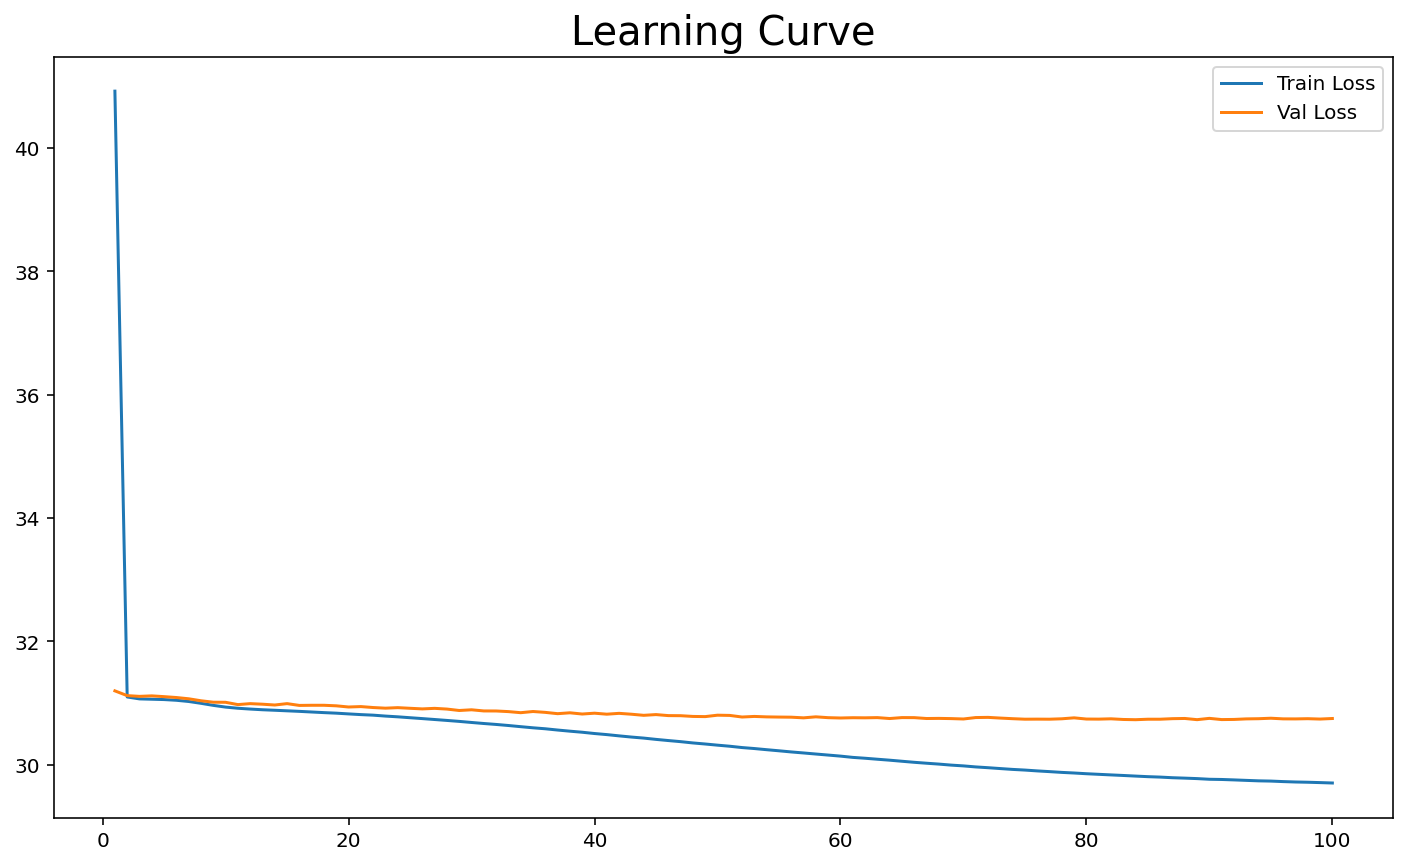

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = GMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_company_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'지역별_GMF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['GMF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['시군구명_label']] = x['시군구명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
model = GMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'지역별_GMF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
df = pd.DataFrame(model.city_embedding.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

gu_idx = [ '노원구', '강서구', '서대문구', '은평구', '강동구', '마포구', '송파구', '강남구', '중랑구', '강북구',
  '영등포구', '동대문구', '양천구', '도봉구', '성북구', '관악구', '구로구', '종로구', '동작구', '서초구',
  '광진구', '성동구', '중구', '용산구', '금천구']

df = df.loc[gu_idx, :]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

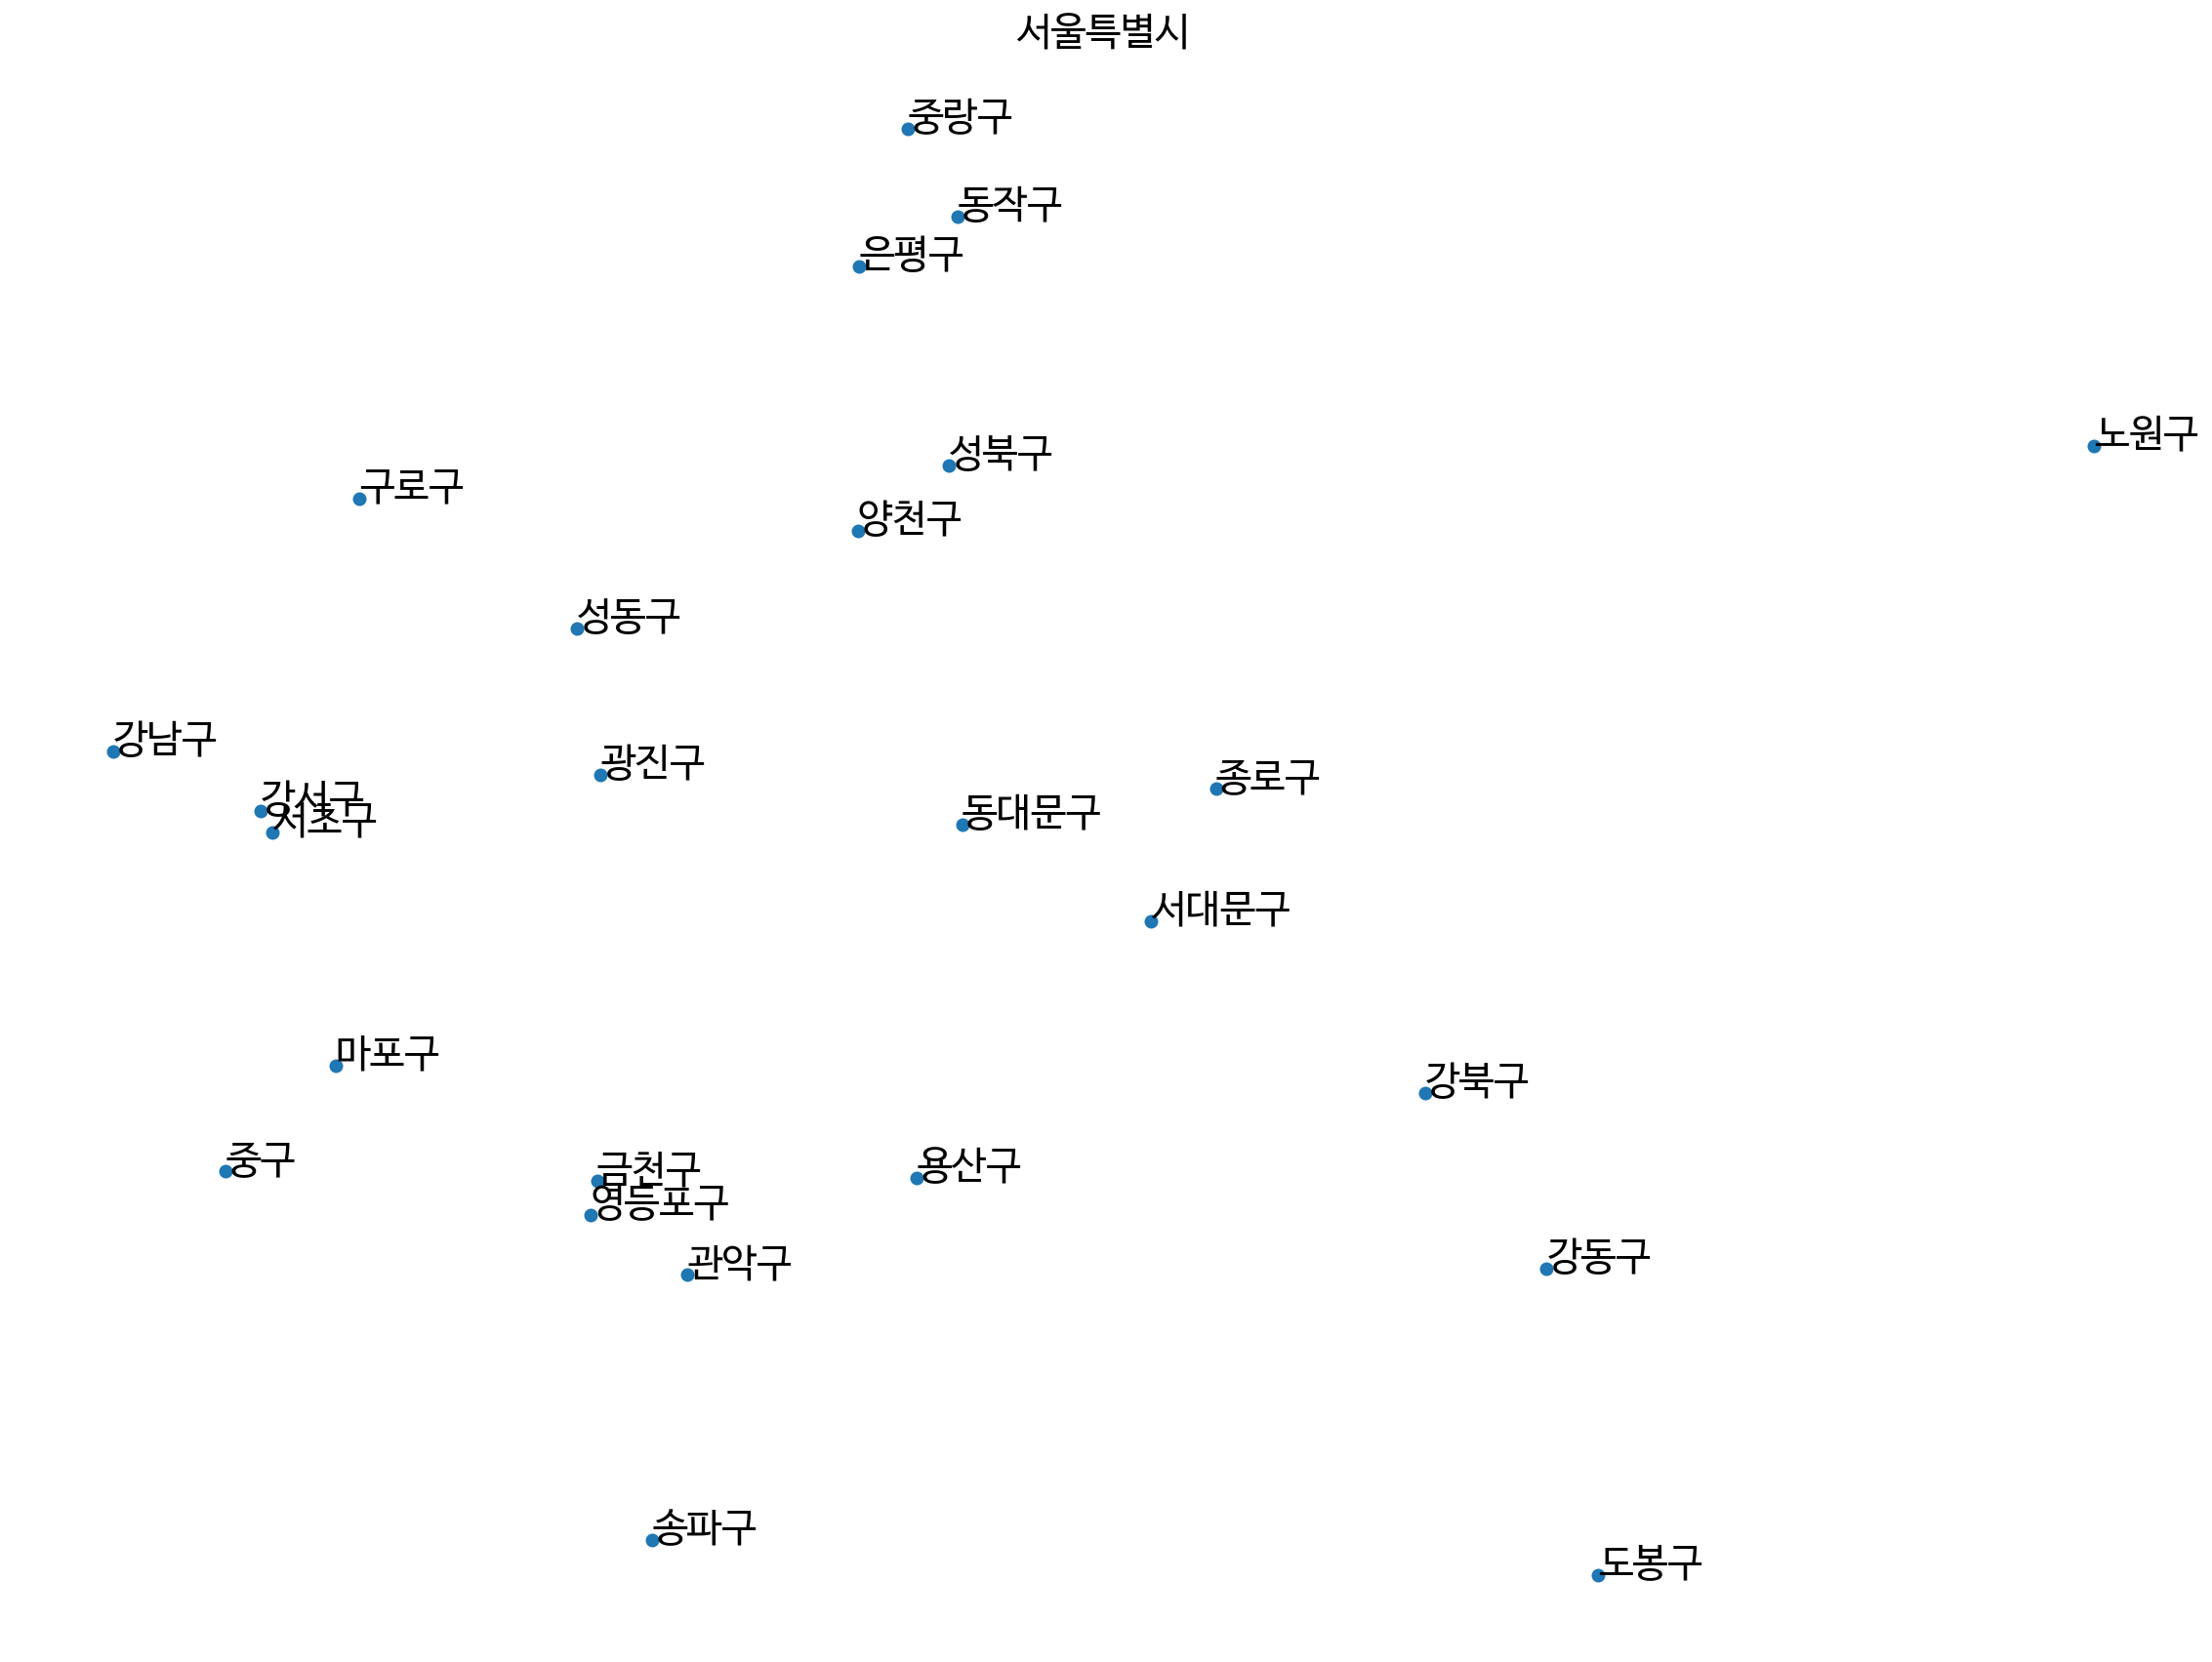

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('서울특별시', fontsize = 20)
ax.axis('off')
plt.show()

### (6) NCF


#### - 모델 정의


In [ ]:
class NCF(nn.Module):
  def __init__(self, city_num, company_num, big_sector_num, middle_sector_num, factor_num):
      super(NCF, self).__init__()

      self.city_embedding = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding = nn.Embedding(middle_sector_num, factor_num)
      self.company_embedding = nn.Embedding(company_num, factor_num)

      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num * 4, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(256),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(128),
          nn.Linear(128, 1),
      )
      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding.weight, std=0.01)
      nn.init.normal_(self.company_embedding.weight, std=0.01)
      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

  def forward(self, city_idx, company_idx, big_sector_idx, middle_sector_idx):
      city_embedding = self.city_embedding(city_idx)
      big_sector_embedding = self.big_sector_embedding(big_sector_idx)
      middle_secto_embedding = self.middle_secto_embedding(middle_sector_idx)
      company_embedding = self.company_embedding(company_idx)

      concat_vactors = torch.cat((city_embedding, big_sector_embedding, middle_secto_embedding, company_embedding), -1)

      out = self.FC_layer(concat_vactors)

      return out.view(-1)

#### - 학습


In [ ]:
model = NCF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_company_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_company_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'지역별_NCF.pt')

  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 37.9245, Val Loss: 30.9899 

[EPOCH: 2], Train Loss: 31.0678, Val Loss: 30.9505 

[EPOCH: 3], Train Loss: 30.9687, Val Loss: 30.9502 

[EPOCH: 4], Train Loss: 30.9064, Val Loss: 30.9167 

[EPOCH: 5], Train Loss: 30.8500, Val Loss: 30.8757 

[EPOCH: 6], Train Loss: 30.8071, Val Loss: 30.8550 

[EPOCH: 7], Train Loss: 30.7523, Val Loss: 30.8585 

[EPOCH: 8], Train Loss: 30.7246, Val Loss: 30.8410 

[EPOCH: 9], Train Loss: 30.6897, Val Loss: 30.8342 

[EPOCH: 10], Train Loss: 30.6535, Val Loss: 30.8129 

[EPOCH: 11], Train Loss: 30.6155, Val Loss: 30.8157 

[EPOCH: 12], Train Loss: 30.5909, Val Loss: 30.7799 

[EPOCH: 13], Train Loss: 30.5635, Val Loss: 30.7777 

[EPOCH: 14], Train Loss: 30.5357, Val Loss: 30.7733 

[EPOCH: 15], Train Loss: 30.5190, Val Loss: 30.7531 

[EPOCH: 16], Train Loss: 30.4895, Val Loss: 30.7512 

[EPOCH: 17], Train Loss: 30.4606, Val Loss: 30.7155 

[EPOCH: 18], Train Loss: 30.4406, Val Loss: 30.7320 

[EPOCH: 19], Train Loss: 30.4320, Val

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 93, Best_Metric : 30.52424728327108


Text(0.5, 1.0, 'Learning Curve')

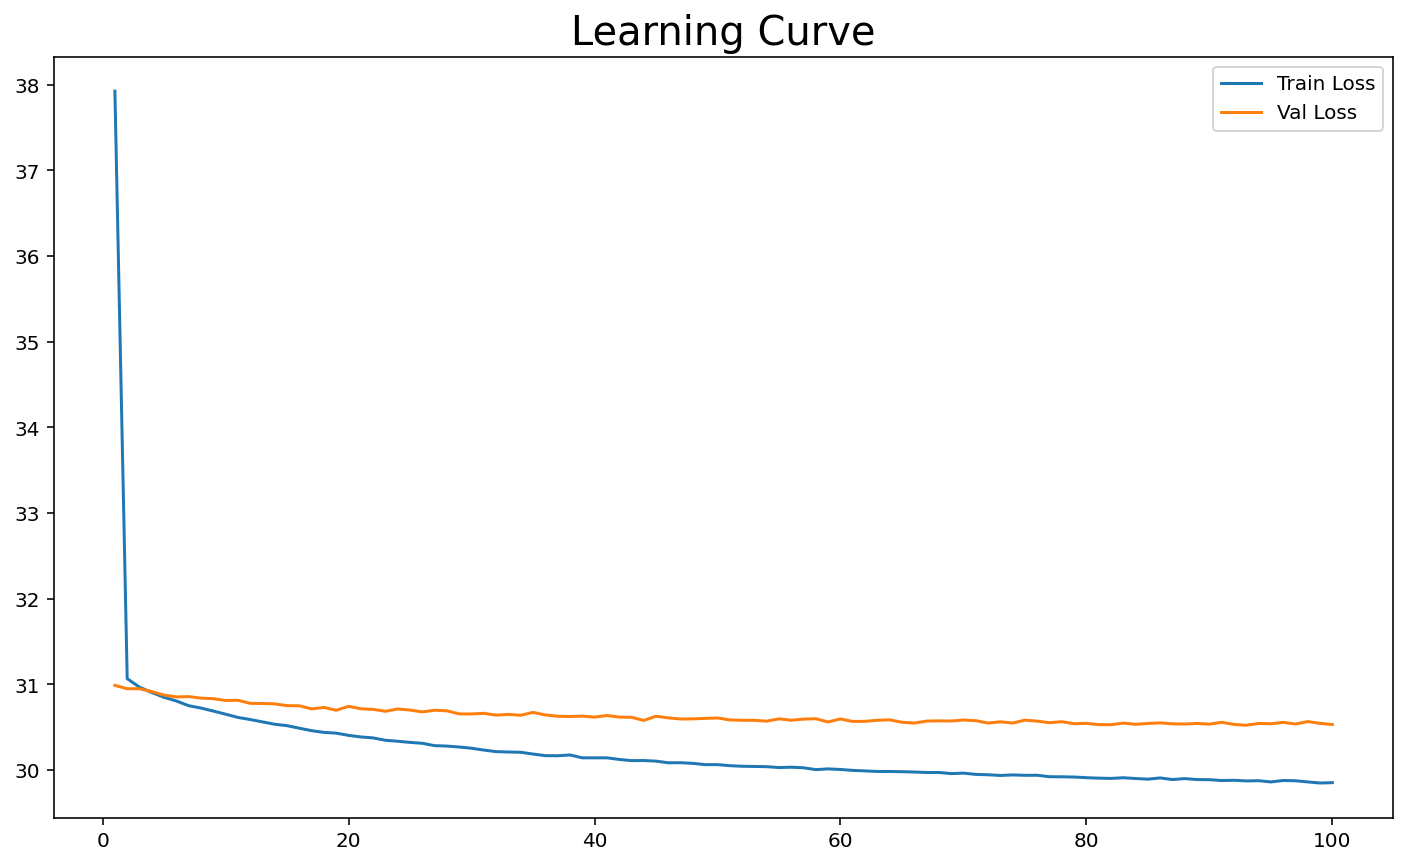

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = NCF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_company_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'지역별_NCF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['NCF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['시군구명_label']] = x['시군구명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
model = NCF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'지역별_NCF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
df = pd.DataFrame(model.city_embedding.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

gu_idx = [ '노원구', '강서구', '서대문구', '은평구', '강동구', '마포구', '송파구', '강남구', '중랑구', '강북구',
  '영등포구', '동대문구', '양천구', '도봉구', '성북구', '관악구', '구로구', '종로구', '동작구', '서초구',
  '광진구', '성동구', '중구', '용산구', '금천구']

df = df.loc[gu_idx, :]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

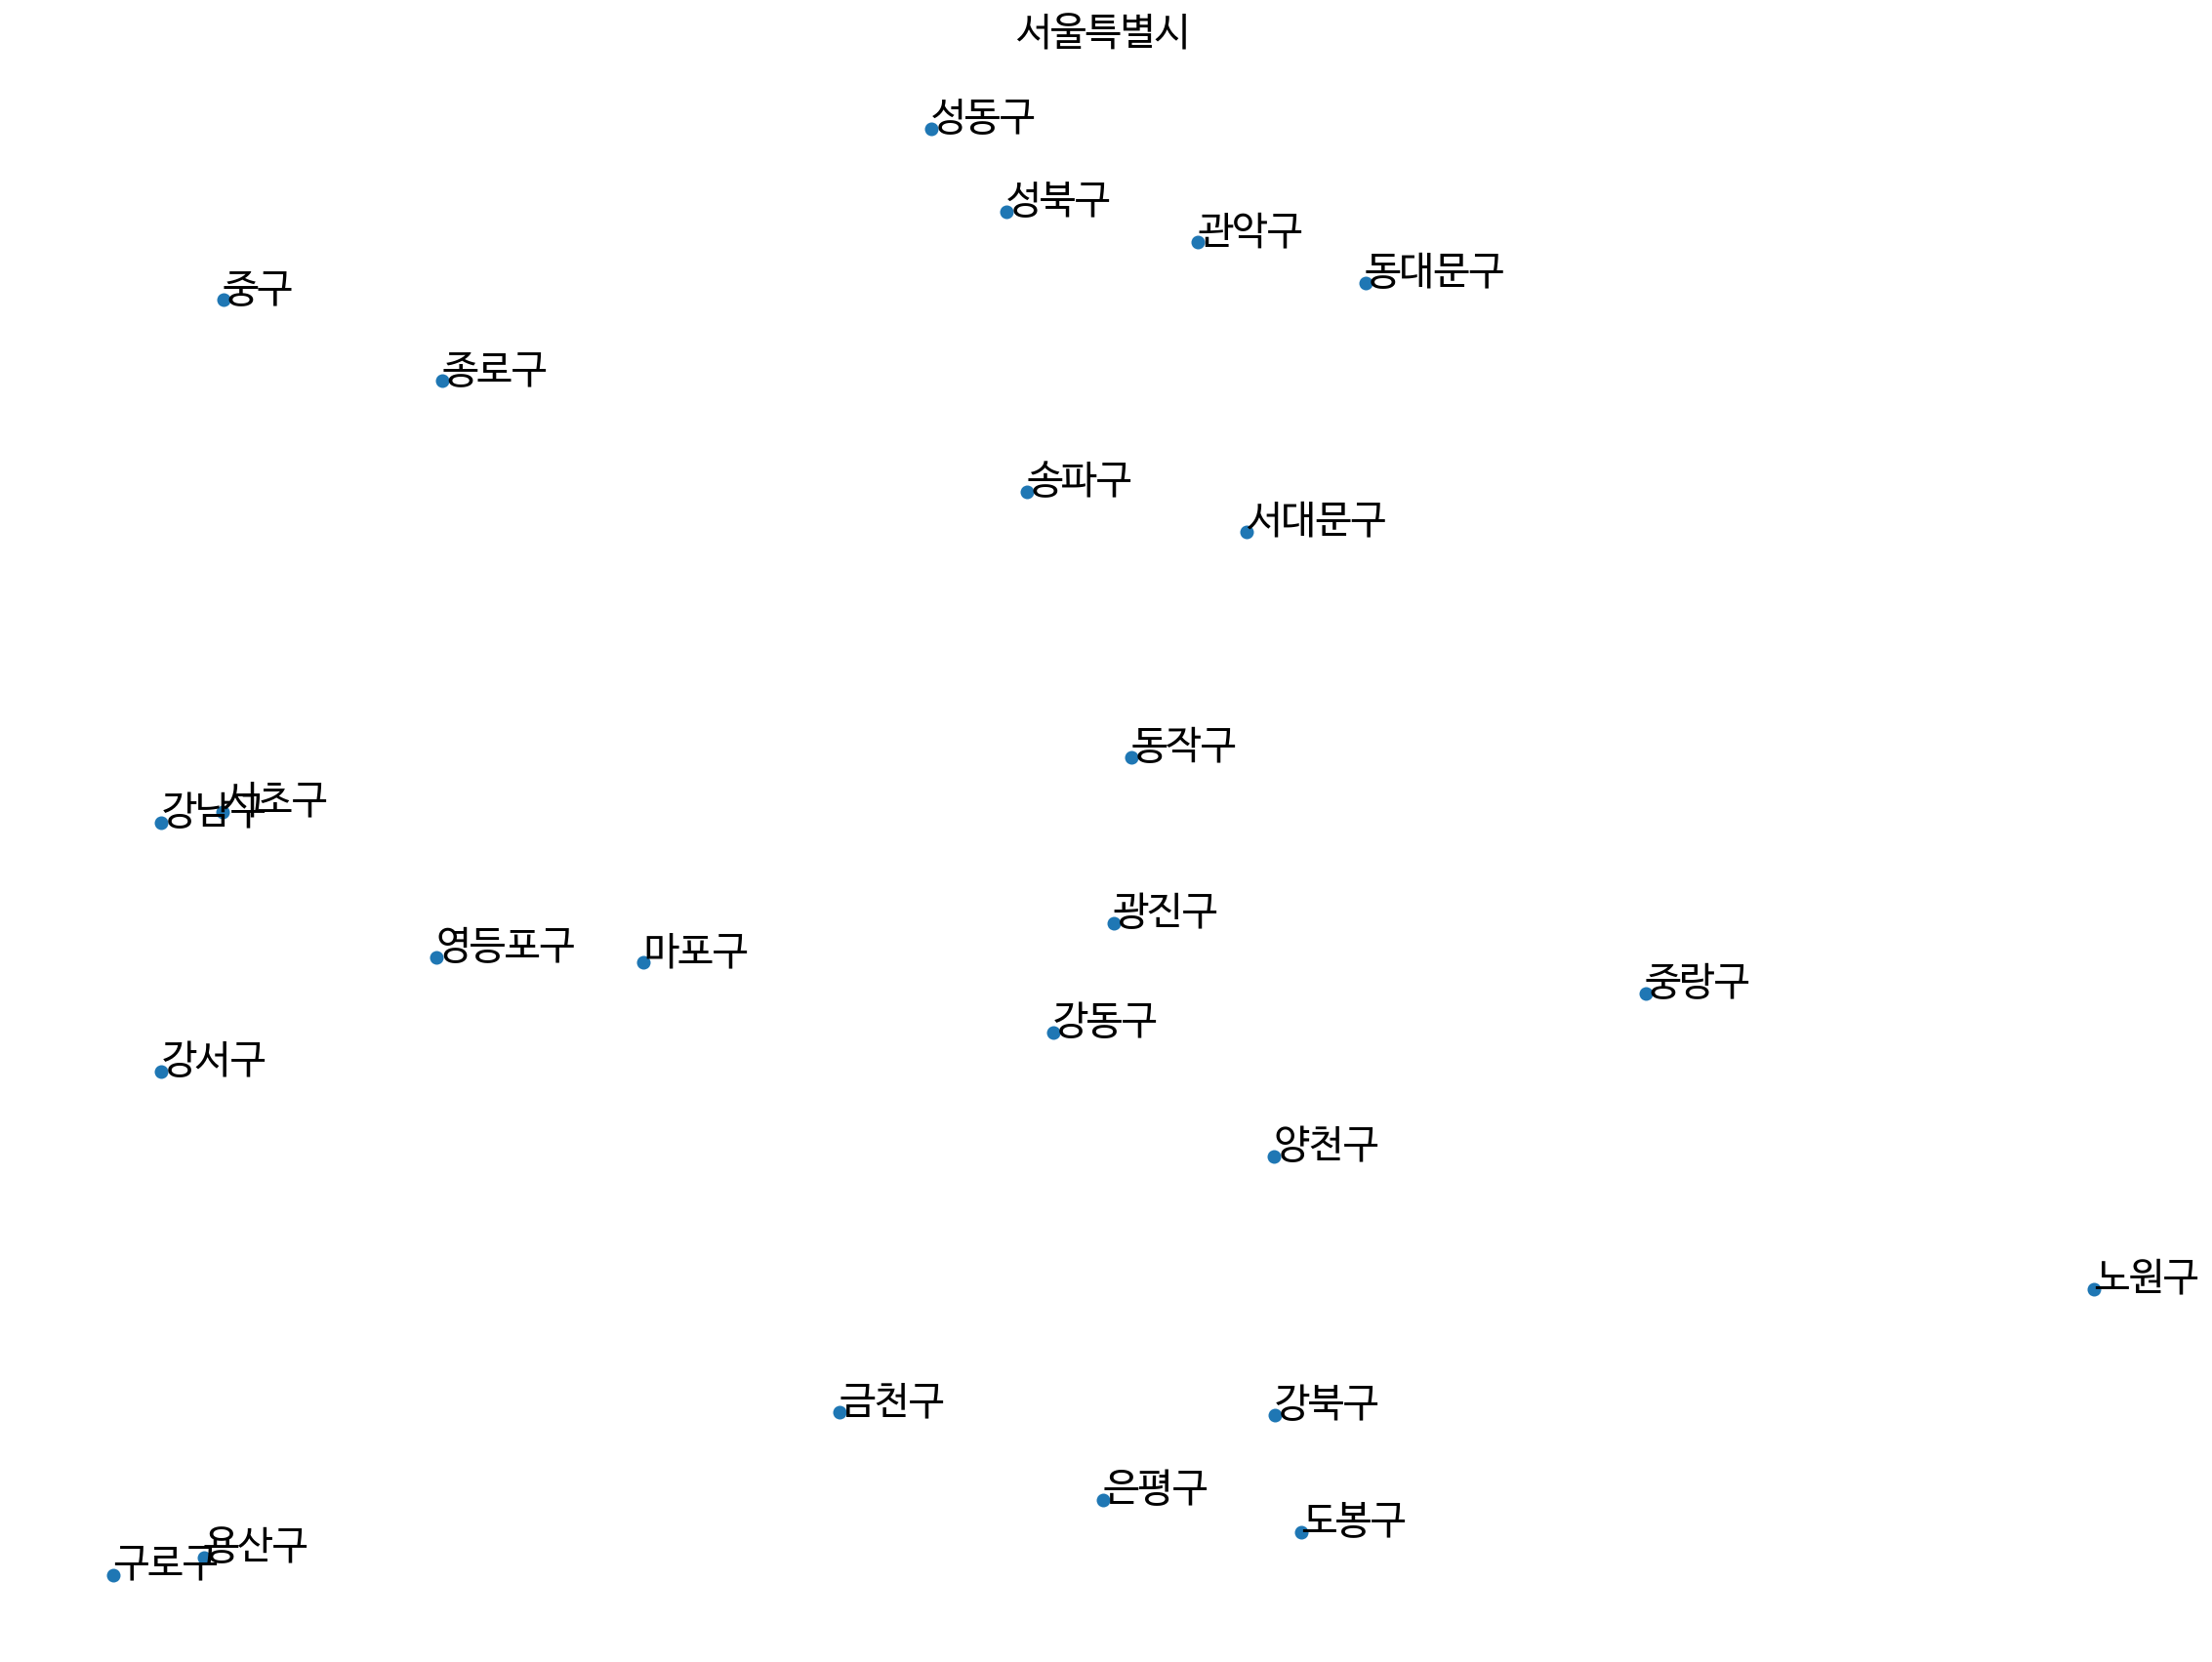

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('서울특별시', fontsize = 20)
ax.axis('off')
plt.show()

### (7) NMF


#### - 모델 정의


In [ ]:
class NMF(nn.Module):
  def __init__(self, city_num, company_num, big_sector_num, middle_sector_num, factor_num):
      super(NMF, self).__init__()

      self.city_embedding_gmf = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding_gmf = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding_gmf = nn.Embedding(middle_sector_num, factor_num)
      self.company_embedding_gmf = nn.Embedding(company_num, factor_num)

      self.city_embedding_ncf = nn.Embedding(city_num, factor_num)
      self.big_sector_embedding_ncf = nn.Embedding(big_sector_num, factor_num)
      self.middle_secto_embedding_ncf = nn.Embedding(middle_sector_num, factor_num)
      self.company_embedding_ncf = nn.Embedding(company_num, factor_num)

      # GMF_FC
      self.GMF_FC = nn.Sequential(
          nn.Linear(factor_num, factor_num)
      )

      # NCF_FC
      self.NCF_FC = nn.Sequential(
          nn.Linear(factor_num * 4, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.BatchNorm1d(256),
          nn.Linear(256, 128),
          nn.ReLU()
      )
      
      # FC
      self.FC_layer = nn.Sequential(
          nn.Linear(factor_num + 128, 1)
      )

      self._init_weight_()

  def _init_weight_(self):
      # weight 초기화
      nn.init.normal_(self.city_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding_gmf.weight, std=0.01)
      nn.init.normal_(self.company_embedding_gmf.weight, std=0.01)

      nn.init.normal_(self.city_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.big_sector_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.middle_secto_embedding_ncf.weight, std=0.01)
      nn.init.normal_(self.company_embedding_ncf.weight, std=0.01)

      for m in self.FC_layer:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)
      
      for m in self.GMF_FC:
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)

      for m in self.NCF_FC:
          if isinstance(m, nn.Linear):
              nn.init.kaiming_uniform_(m.weight)

  def forward(self, city_idx, company_idx, big_sector_idx, middle_sector_idx):
      city_embedding_gmf = self.city_embedding_gmf(city_idx)
      big_sector_embedding_gmf = self.big_sector_embedding_gmf(big_sector_idx)
      middle_secto_embedding_gmf = self.middle_secto_embedding_gmf(middle_sector_idx)
      company_embedding_gmf = self.company_embedding_gmf(company_idx)

      city_embedding_ncf = self.city_embedding_ncf(city_idx)
      big_sector_embedding_ncf = self.big_sector_embedding_ncf(big_sector_idx)
      middle_secto_embedding_ncf = self.middle_secto_embedding_ncf(middle_sector_idx)
      company_embedding_ncf = self.company_embedding_ncf(company_idx)

      element_wise_product = (city_embedding_gmf * big_sector_embedding_gmf * middle_secto_embedding_gmf * company_embedding_gmf)
      element_wise_product = self.GMF_FC(element_wise_product)

      concat_vactors = torch.cat((city_embedding_ncf, big_sector_embedding_ncf, middle_secto_embedding_ncf, company_embedding_ncf), -1)
      concat_vactors = self.NCF_FC(concat_vactors)
      
      out = torch.cat((element_wise_product, concat_vactors), -1)
      out = self.FC_layer(out)

      return out.view(-1)

#### - 학습


In [ ]:
model = NMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = GMFData(train_city_idx_li, train_company_idx_li, train_big_sector_idx_li, train_middle_sector_idx_li, train_label_li)
train_loader = DataLoader(train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

val_dataset = GMFData(val_city_idx_li, val_company_idx_li, val_big_sector_idx_li, val_middle_sector_idx_li, val_label_li)
val_loader = DataLoader(val_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

best_metric = 100000000
best_epoch = 0
result_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  test_loss = evaluate(model, val_loader)

  train_loss = np.sqrt(train_loss)
  test_loss = np.sqrt(test_loss)

  if test_loss < best_metric:

    best_metric = test_loss
    best_epoch = epoch
    torch.save(model.state_dict(), MODEL_DIR + f'지역별_NMF.pt')

  result_list.append({
      'EPOCH': epoch,
      'Train Loss': train_loss,
      'Val Loss': test_loss})

  print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f} \n")

[EPOCH: 1], Train Loss: 32.2497, Val Loss: 30.9936 

[EPOCH: 2], Train Loss: 30.9396, Val Loss: 30.9209 

[EPOCH: 3], Train Loss: 30.7372, Val Loss: 30.9966 

[EPOCH: 4], Train Loss: 30.6015, Val Loss: 30.8154 

[EPOCH: 5], Train Loss: 30.5007, Val Loss: 30.8506 

[EPOCH: 6], Train Loss: 30.4093, Val Loss: 30.8012 

[EPOCH: 7], Train Loss: 30.3333, Val Loss: 30.7754 

[EPOCH: 8], Train Loss: 30.2610, Val Loss: 30.7496 

[EPOCH: 9], Train Loss: 30.1839, Val Loss: 30.7401 

[EPOCH: 10], Train Loss: 30.1151, Val Loss: 30.7727 

[EPOCH: 11], Train Loss: 30.0518, Val Loss: 30.7190 

[EPOCH: 12], Train Loss: 30.0019, Val Loss: 30.7135 

[EPOCH: 13], Train Loss: 29.9514, Val Loss: 30.6885 

[EPOCH: 14], Train Loss: 29.9124, Val Loss: 30.6846 

[EPOCH: 15], Train Loss: 29.8679, Val Loss: 30.7061 

[EPOCH: 16], Train Loss: 29.8396, Val Loss: 30.7007 

[EPOCH: 17], Train Loss: 29.8092, Val Loss: 30.7079 

[EPOCH: 18], Train Loss: 29.7855, Val Loss: 30.6672 

[EPOCH: 19], Train Loss: 29.7578, Val

#### - 학습 결과


In [ ]:
print(f'Best_Epoch : {best_epoch}, Best_Metric : {best_metric}')

Best_Epoch : 75, Best_Metric : 30.627889753759035


Text(0.5, 1.0, 'Learning Curve')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


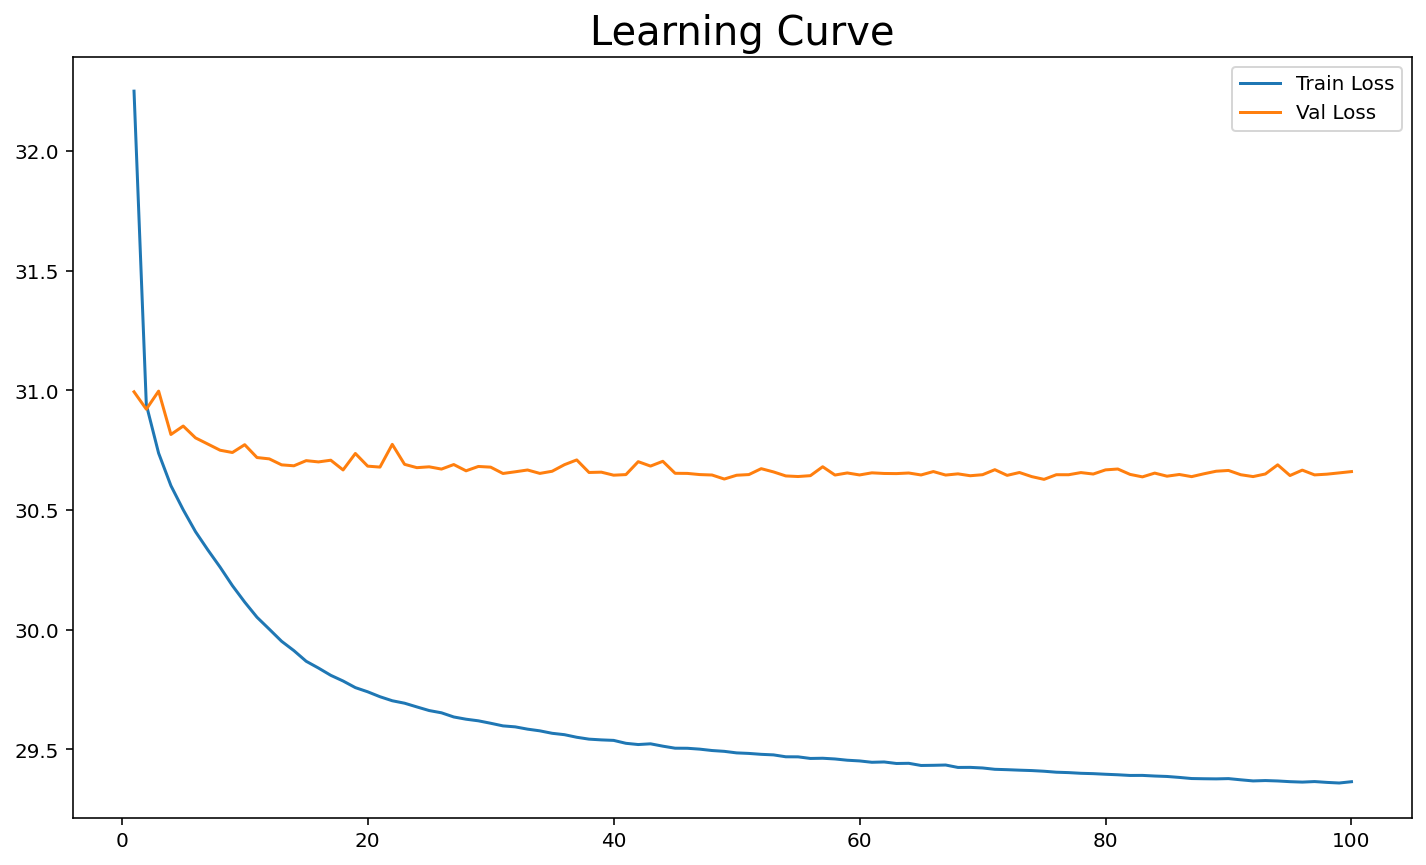

In [ ]:
result_df = pd.DataFrame(result_list)
plt.figure(figsize=(12, 7))

plt.plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
plt.plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
plt.legend()
plt.title('Learning Curve', fontsize = 20)

#### - 예측


In [ ]:
model = NMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)

test_dataset = GMFData(test_city_idx_li, test_company_idx_li, test_big_sector_idx_li, test_middle_sector_idx_li)

test_loader = DataLoader(test_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

model.load_state_dict(torch.load(MODEL_DIR + f'지역별_NMF.pt', map_location = DEVICE))

test_label_li = get_test_label(model, test_loader)

Test_df['NMF_eval_label'] = test_label_li

#### - 임베딩 시각화


In [ ]:
idx2city = {}

def get_idx2city(x):
    idx2city[x['시군구명_label']] = x['시군구명']

_ = all_df.apply(lambda x : get_idx2city(x), axis = 1)

In [ ]:
model = NMF(city_num, company_num, big_sector_num, middle_sector_num, factor_num).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR + f'지역별_NMF.pt', map_location = DEVICE))

<All keys matched successfully>

In [ ]:
df = pd.DataFrame(model.city_embedding_gmf.weight.cpu().detach().numpy() * model.city_embedding_ncf.weight.cpu().detach().numpy())
df['index'] = df.index
df['index'] = df['index'].map(idx2city)
df = df.set_index('index')

gu_idx = [ '노원구', '강서구', '서대문구', '은평구', '강동구', '마포구', '송파구', '강남구', '중랑구', '강북구',
  '영등포구', '동대문구', '양천구', '도봉구', '성북구', '관악구', '구로구', '종로구', '동작구', '서초구',
  '광진구', '성동구', '중구', '용산구', '금천구']

df = df.loc[gu_idx, :]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(df)

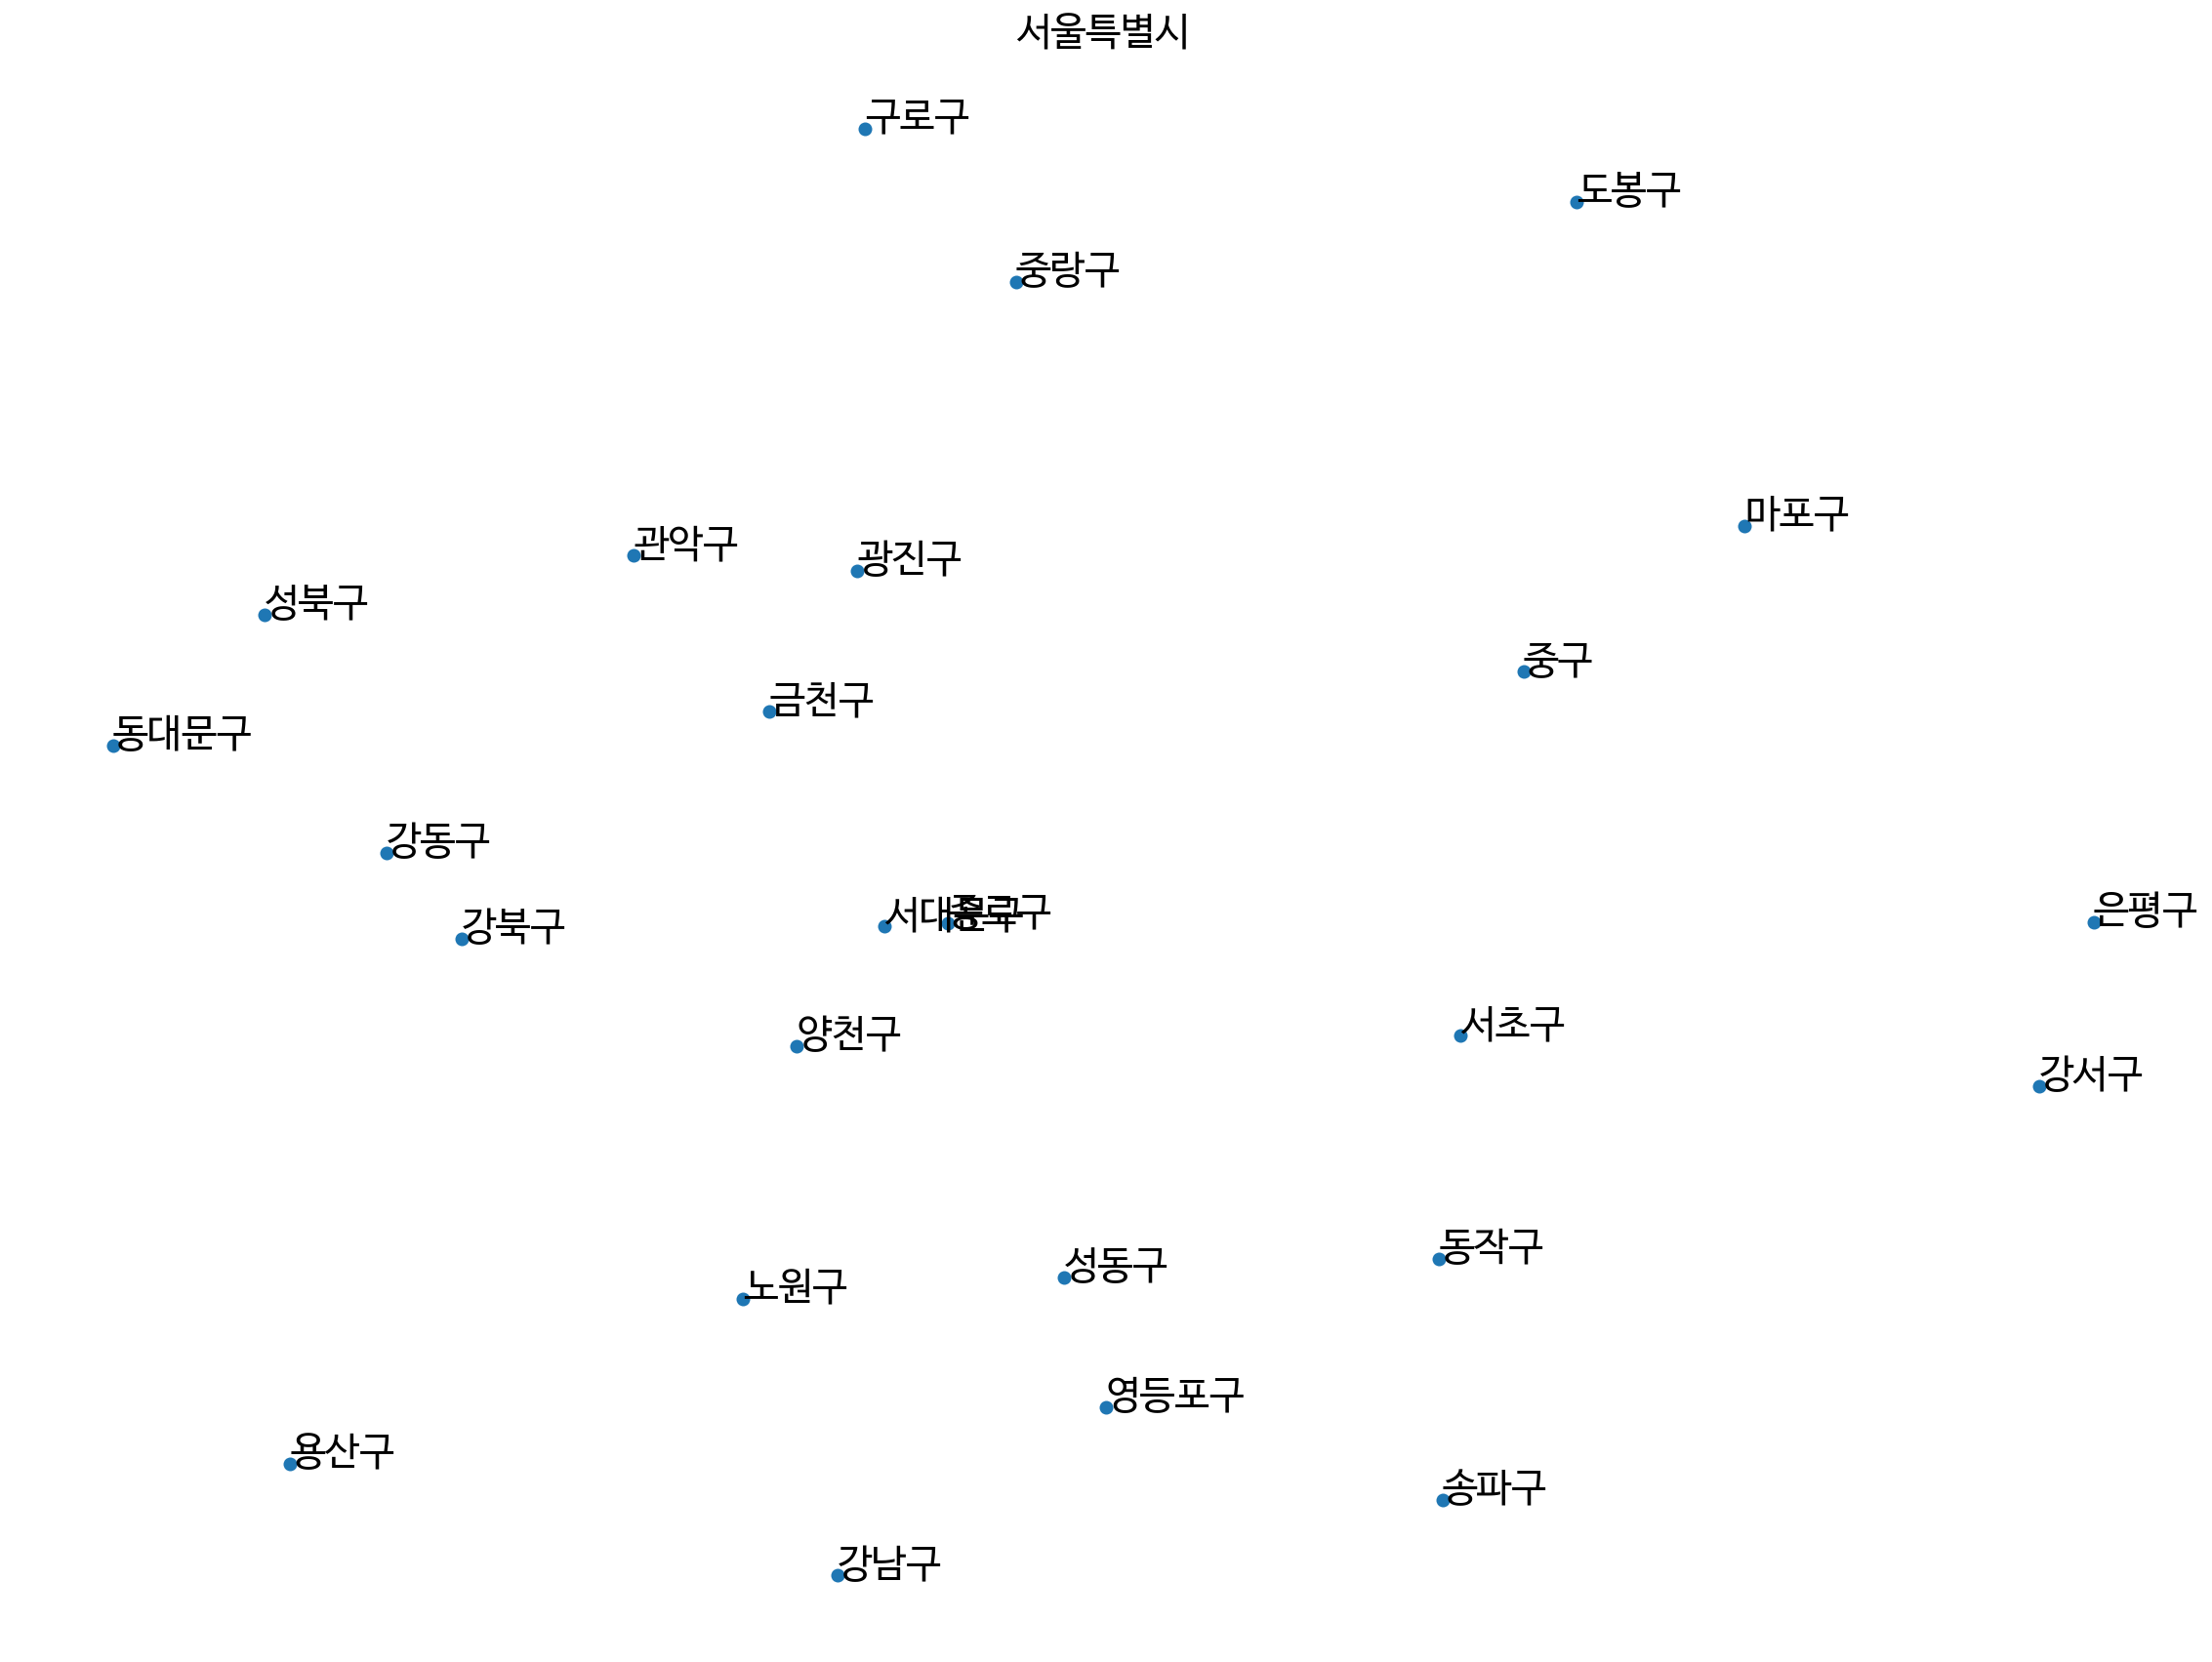

In [ ]:
from sklearn.decomposition import PCA

vocab = df.index.tolist()
X = cos_sim

pca = PCA(n_components=2, random_state = 22)
X_show = pca.fit_transform(X)

df = pd.DataFrame(X_show, index = vocab, columns = ['x', 'y'])
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
  ax.annotate(word, pos, fontsize = 20)
plt.title('서울특별시', fontsize = 20)
ax.axis('off')
plt.show()

### (8) 결과



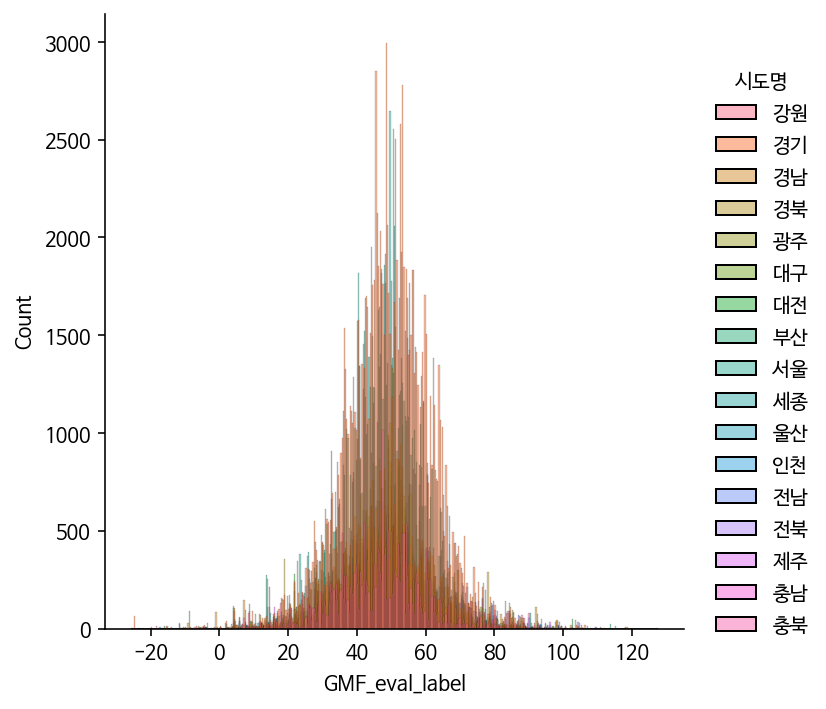

In [ ]:
sns.displot(data = Test_df, x = 'GMF_eval_label', hue = '시도명')

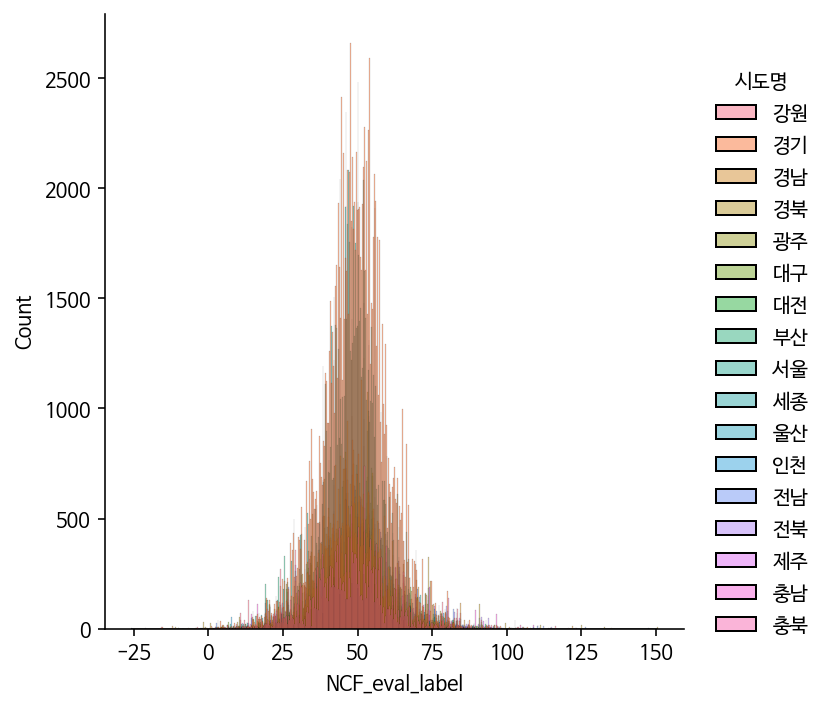

In [ ]:
sns.displot(data = Test_df, x = 'NCF_eval_label', hue = '시도명')

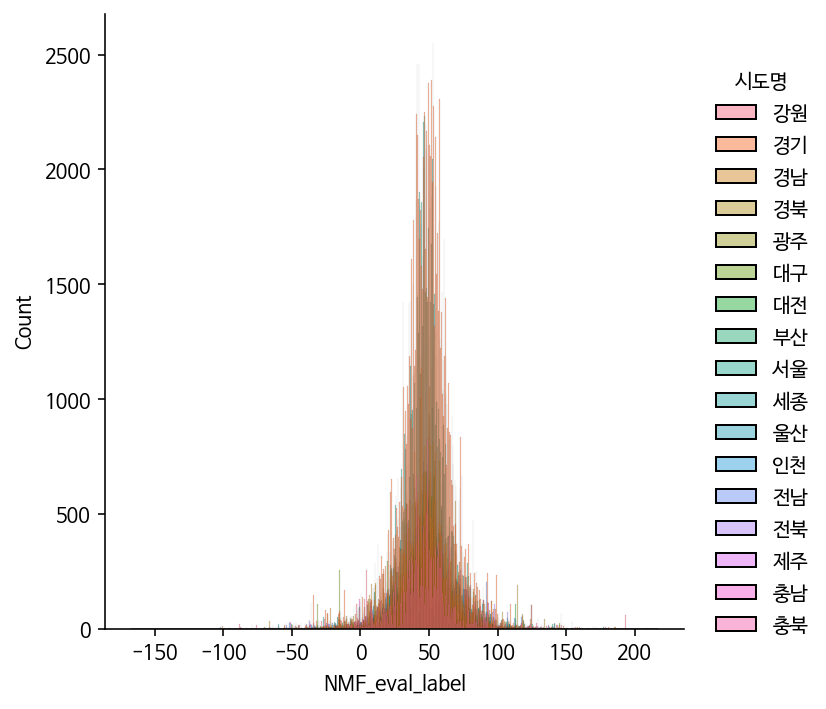

In [ ]:
sns.displot(data = Test_df, x = 'NMF_eval_label', hue = '시도명')

# 3. Tableau 시각화

## 3-1. 지역별 통계 데이터
### (1) 전국

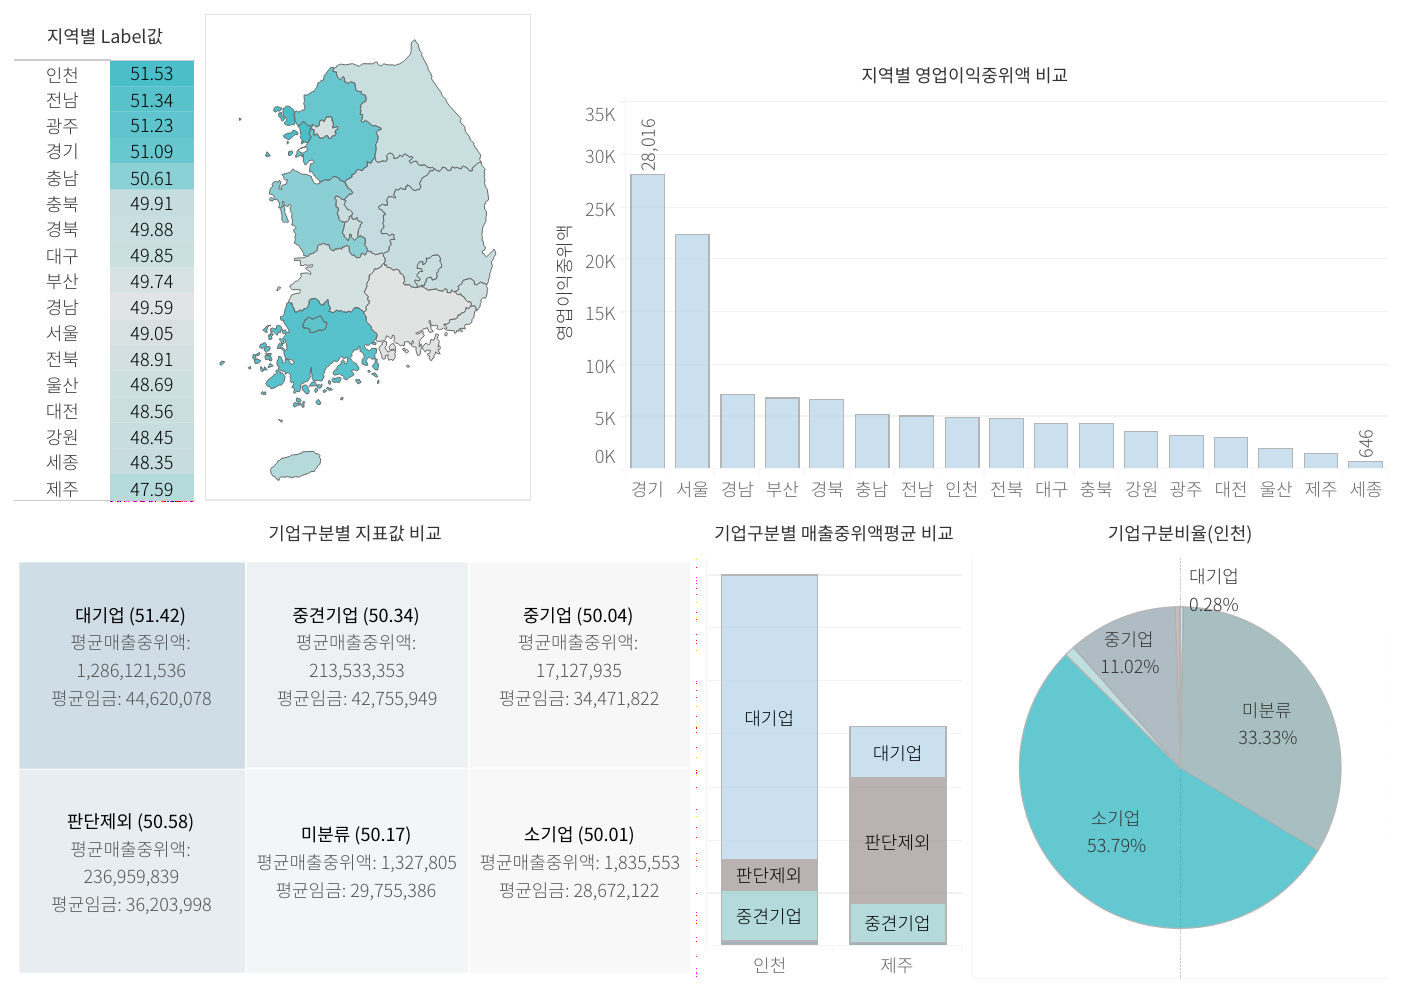

### (2) 서울시 (신한은행 서울시 데이터)

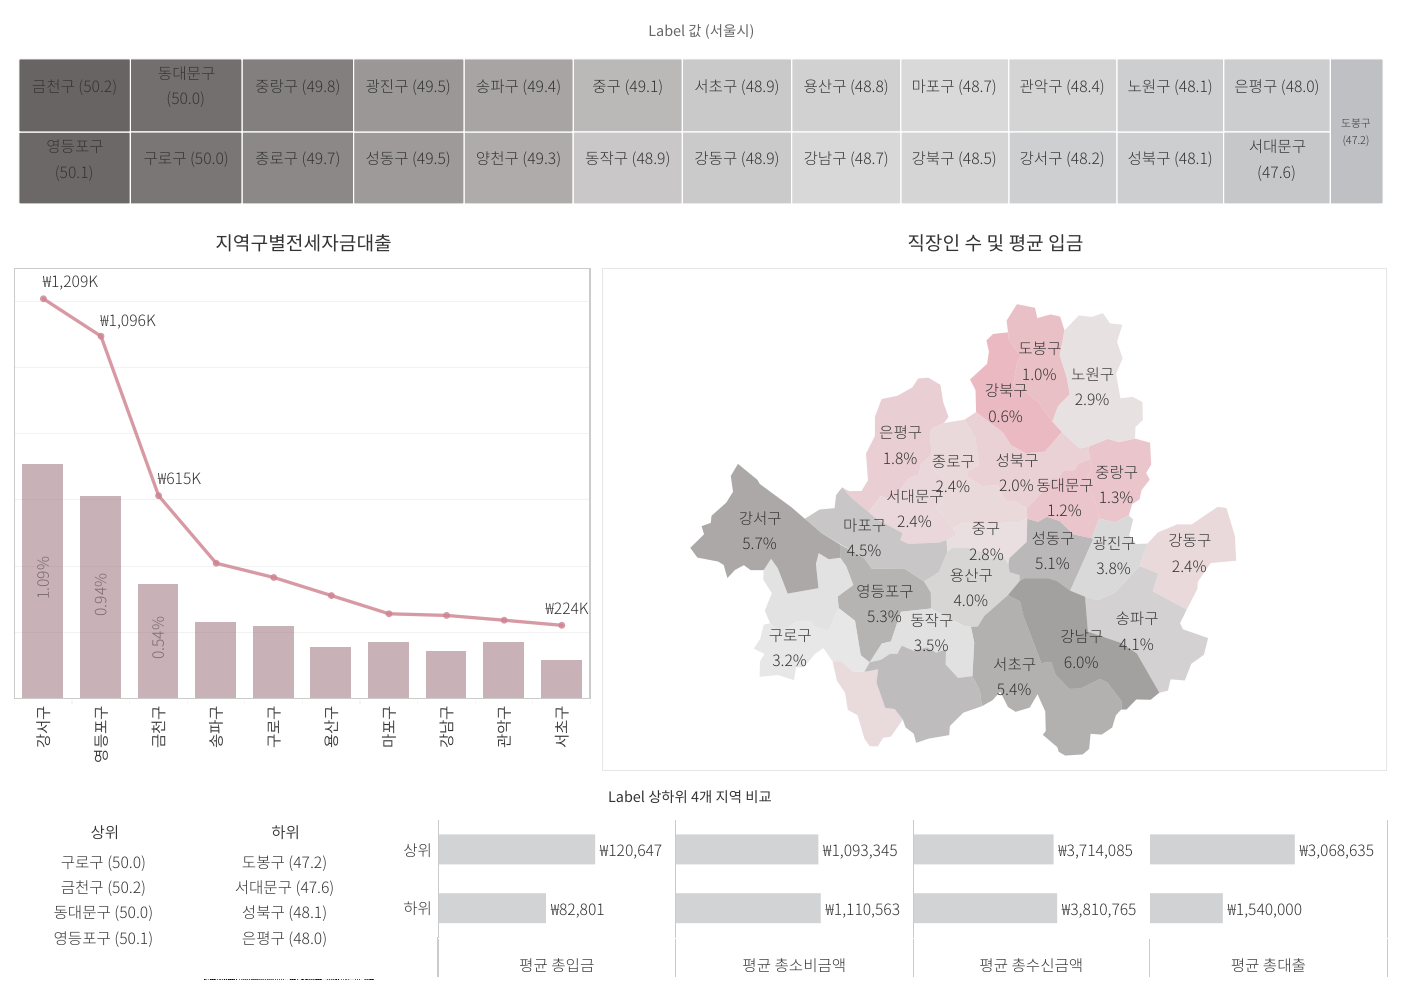

## 3-2. 광역시도별 업종별 가맹점 데이터

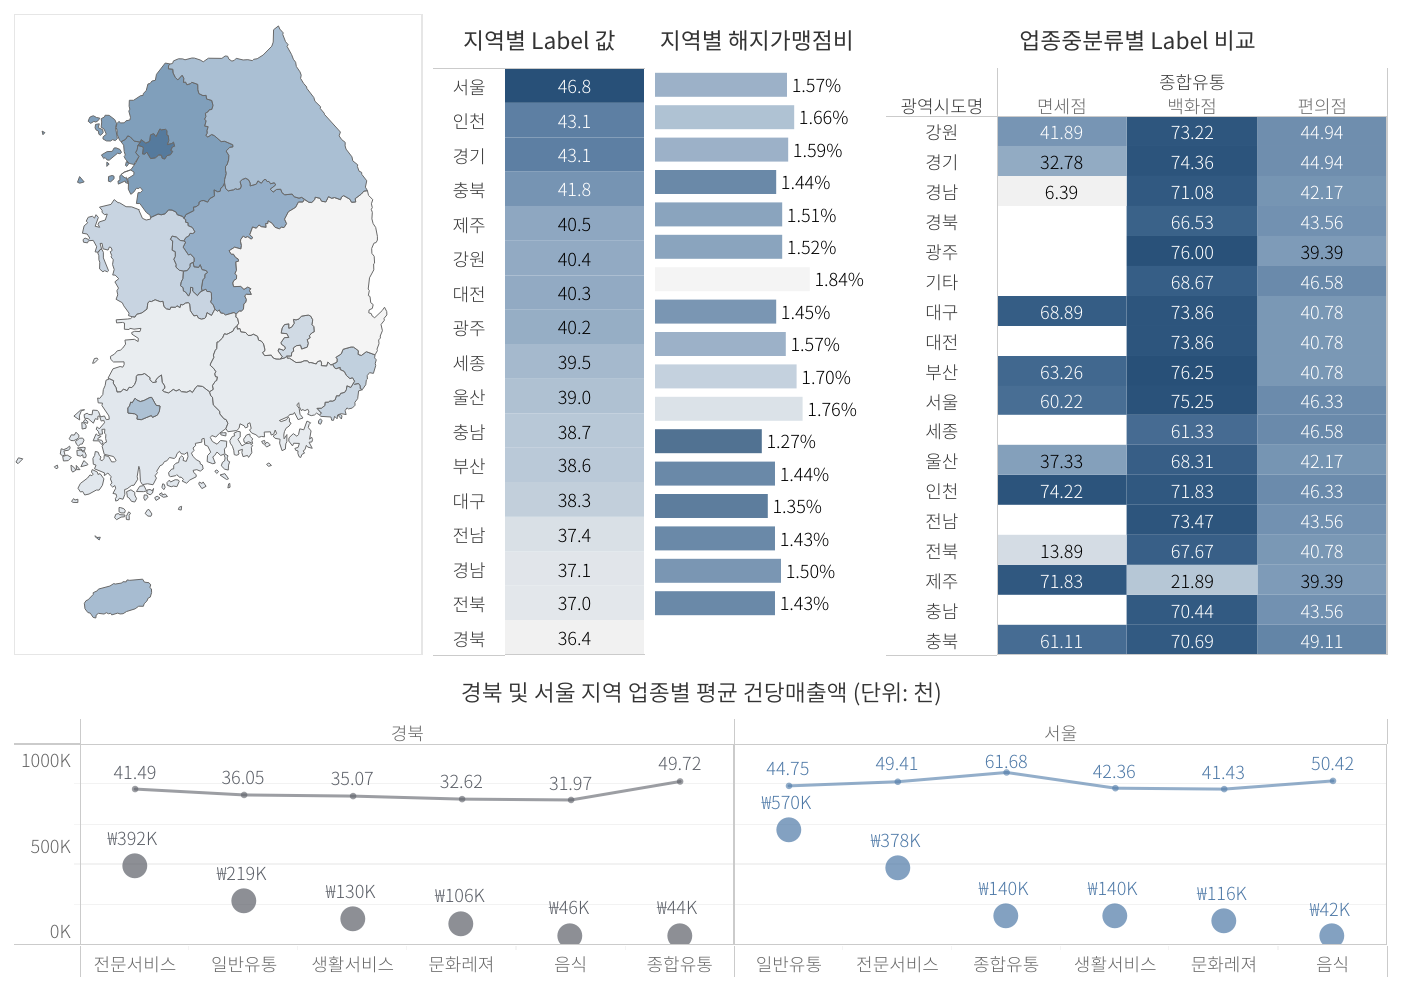